# File Compaction Notebook

This notebook performs the following operations:

- Create Delta Lake tables
- Generate data and insert it into the table
- Compact files
- Display table properties
- Run queries
- Display query execution time

In [90]:
spark.stop()

In [2]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("Compaction") \
    .master("spark://192.168.0.144:7077") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://192.168.0.144:9083") \
    .config("spark.hadoop.javax.jdo.option.ConnectionURL", "jdbc:mysql://192.168.0.144:3306/metastore_db") \
    .config("spark.hadoop.javax.jdo.option.ConnectionDriverName", "com.mysql.cj.jdbc.Driver") \
    .config("spark.hadoop.javax.jdo.option.ConnectionUserName", "lh") \
    .config("spark.hadoop.javax.jdo.option.ConnectionPassword", os.getenv('MYSQL', 'Default_Value')) \
    .config("spark.jars", "/usr/local/spark/jars/delta-storage-3.2.0.jar,/usr/local/spark/jars/delta-spark_2.12-3.2.0.jar")    \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.HDFSLogStore") \
    .config("spark.executor.memory", "9g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "19g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.0.144:9000") \
    .config("spark.databricks.delta.clusteredTable.enableClusteringTablePreview", "true") \
    .config("spark.sql.debug.maxToStringFields", "1000") \
    .enableHiveSupport() \
    .getOrCreate()

24/08/05 19:15:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
db='compaction'
delta_db_path = 'hdfs://192.168.0.144:9000/datalake/compaction'

In [4]:
#spark.sql(f"drop DATABASE {db} CASCADE")
#spark.sql(f"CREATE DATABASE {db} LOCATION '{delta_db_path}'")
spark.sql(f"use database {db}")

DataFrame[]

In [ ]:
num = 3  # Number of tables to create
max_rows = 8  # Maximum number of rows for the largest table 8000000000

row_counts = [max_rows // (2 ** i) for i in range(num)]

for i in range(num):
    compaction_table_name = f"compaction_table_{row_counts[i]}"
    spark.sql(f"DROP TABLE IF EXISTS {compaction_table_name}")   
    spark.sql(f"""
    CREATE TABLE {compaction_table_name} (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)

In [6]:
table_pairs = [
    ('compaction.compaction_table_8', 'raw_data.raw_data_8'),
    ('compaction.compaction_table_4', 'raw_data.raw_data_4'),
    ('compaction.compaction_table_2', 'raw_data.raw_data_2')
]

for target_table, source_table in table_pairs:
    insert_sql = f"""
    INSERT INTO {target_table}
    SELECT * FROM {source_table}
    """
    print(f"Inserting data for table {target_table}")
    %time spark.sql(insert_sql)

Inserting data for table compaction.compaction_table_8


CPU times: user 2.9 s, sys: 2.72 s, total: 5.63 s
Wall time: 2h 22min 29s
Inserting data for table compaction.compaction_table_4


CPU times: user 1.37 s, sys: 1.46 s, total: 2.83 s
Wall time: 1h 8min 57s
Inserting data for table compaction.compaction_table_2


CPU times: user 746 ms, sys: 731 ms, total: 1.48 s
Wall time: 35min 27s


In [84]:
tables_df = spark.sql("SHOW TABLES")
tables = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]
print(tables)

['compaction_table_2', 'compaction_table_4', 'compaction_table_8']


In [61]:
tables_df = spark.sql("SHOW TABLES")
tables = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]

for table in tables:
    spark.sql(f"describe {table}").show(truncate=False)
    spark.sql(f"describe detail {table}").show(truncate=False)

+-------------+---------+-------+
|col_name     |data_type|comment|
+-------------+---------+-------+
|timestamp    |timestamp|NULL   |
|value        |double   |NULL   |
|country      |string   |NULL   |
|event_id     |bigint   |NULL   |
|actor_id     |bigint   |NULL   |
|year         |int      |NULL   |
|month        |bigint   |NULL   |
|day          |bigint   |NULL   |
|product_id   |int      |NULL   |
|location_id  |int      |NULL   |
|department_id|int      |NULL   |
|campaign_id  |int      |NULL   |
|customer_id  |int      |NULL   |
+-------------+---------+-------+

+------+------------------------------------+-------------------------------------------+-----------+----------------------------------------------------------------+----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                                

In [ ]:
from pyspark.sql import SparkSession
from py4j.java_gateway import java_import

java_import(spark._jvm, "org.apache.hadoop.fs.FileSystem")
java_import(spark._jvm, "org.apache.hadoop.fs.Path")

def list_hdfs_directory(hdfs_path, level=0):
    hadoop_conf = spark._jsc.hadoopConfiguration()
    fs = spark._jvm.FileSystem.get(hadoop_conf)
    path = spark._jvm.Path(hdfs_path)
    
    if level == 0:
        print(f"Listing contents of: {hdfs_path}")
    
    status = fs.listStatus(path)
    
    for file_status in status:
        file_path = file_status.getPath()
        is_dir = file_status.isDirectory()
        size = file_status.getLen() if not is_dir else 0
        indent = ' ' * (level * 2)
        if is_dir:
            print(f"{indent}- {file_path.getName()}/")
            list_hdfs_directory(file_path.toString(), level + 1)
        else:
            size_mb = size / (1024 * 1024)
            print(f"{indent}- {file_path.getName()} ({size_mb:.2f} MB)")

In [ ]:
list_hdfs_directory(delta_db_path)

Listing contents of: hdfs://192.168.0.144:9000/datalake/compaction
- compaction_table_2/
  - _delta_log/
    - 00000000000000000000.json (0.00 MB)
    - 00000000000000000001.json (0.32 MB)
    - _commits/
  - part-00000-373df4b4-6cec-423e-b4a6-10c1eb47d792-c000.snappy.parquet (128.34 MB)
  - part-00001-c51420cc-f6ca-4f8a-b487-8cbf0d40224f-c000.snappy.parquet (127.93 MB)
  - part-00002-8f6504f8-4be0-4f1a-9efb-a886f876c69e-c000.snappy.parquet (127.92 MB)
  - part-00003-edfedc7d-3e71-4f35-9f09-3d174c9bbcf4-c000.snappy.parquet (128.34 MB)
  - part-00004-bd485084-14c5-4cbf-a89f-0bd030affe73-c000.snappy.parquet (127.92 MB)
  - part-00005-0d09fcbd-ce09-4326-bced-3b652e7cfe6e-c000.snappy.parquet (127.92 MB)
  - part-00006-3fa70d48-1cde-47d1-960d-5e86f94102f9-c000.snappy.parquet (128.34 MB)
  - part-00007-038c23d7-512a-461d-a990-c8132019ff2b-c000.snappy.parquet (127.93 MB)
  - part-00008-a9bfda7b-0079-4327-b05b-26ca5e27853f-c000.snappy.parquet (127.93 MB)
  - part-00009-36b27442-a45b-499c-be40-

In [10]:
import os
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_table_details(spark, tables):
    os.environ['HADOOP_HOME'] = '/usr/local/hadoop'
    os.environ['PATH'] = os.environ['PATH'] + ':' + os.environ['HADOOP_HOME'] + '/bin'

    table_details = []

    for table_name in tables:
        describe_df = spark.sql(f"DESCRIBE DETAIL {table_name}")
        describe_detail = describe_df.collect()[0].asDict()
        hdfs_location = describe_detail['location']
        num_files = describe_detail['numFiles']
        partition_columns = describe_detail['partitionColumns']
        
        result = subprocess.run(["hdfs", "dfs", "-du", "-s", hdfs_location], capture_output=True, text=True)
        size_bytes = int(result.stdout.split()[0])
        size_gb = size_bytes / (1024 ** 3)  
        
        count_result = subprocess.run(["hdfs", "dfs", "-count", hdfs_location], capture_output=True, text=True)
        subdirectories = int(count_result.stdout.split()[0]) - 1  
        
        row_count_df = spark.sql(f"SELECT COUNT(*) AS row_count FROM {table_name}")
        row_count = row_count_df.collect()[0]['row_count']
        
        table_details.append((table_name, hdfs_location, size_gb, num_files, partition_columns, subdirectories, row_count))

    for table in table_details:
        print(f"Table: {table[0]}, HDFS Directory: {table[1]}, Size: {table[2]:.2f} GB, Number of Files: {table[3]}, Partition Columns: {table[4]}, Subdirectories: {table[5]}, Number of Rows: {table[6]}")

    table_names = [table[0] for table in table_details]
    sizes = [table[2] for table in table_details]  
    num_files = [table[3] for table in table_details]
    subdirectories = [table[5] for table in table_details]
    row_counts = [table[6] for table in table_details]

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['DejaVu Serif']
    sns.set(style="whitegrid")

    fig, axs = plt.subplots(4, 1, figsize=(10, 12))

    font_size = 14

    def add_values_to_bars(ax, rects, fmt='{:.2f}'):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(fmt.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, -18), 
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=font_size, color='black',
                        fontfamily='serif', fontname='DejaVu Serif')

    for ax in axs:
        ax.set_axisbelow(True)
        ax.grid(True, which='both', linewidth=1) 

    rects0 = axs[0].bar(table_names, sizes, color=sns.color_palette("muted"))
    axs[0].set_title('Table Sizes', fontsize=font_size)
    axs[0].set_ylabel('Size (GB)', fontsize=font_size)
    axs[0].tick_params(axis='both', which='major', labelsize=font_size)
    add_values_to_bars(axs[0], rects0)

    rects1 = axs[1].bar(table_names, num_files, color=sns.color_palette("muted"))
    axs[1].set_title('Number of Files', fontsize=font_size)
    axs[1].set_ylabel('Files', fontsize=font_size)
    axs[1].tick_params(axis='both', which='major', labelsize=font_size)
    add_values_to_bars(axs[1], rects1, fmt='{:.0f}')

    rects2 = axs[2].bar(table_names, subdirectories, color=sns.color_palette("muted"))
    axs[2].set_title('Number of Subdirectories (only relevant for partitioning)', fontsize=font_size)
    axs[2].set_ylabel('Subdirectories', fontsize=font_size)
    axs[2].tick_params(axis='both', which='major', labelsize=font_size)
    add_values_to_bars(axs[2], rects2, fmt='{:.0f}')

    rects3 = axs[3].bar(table_names, row_counts, color=sns.color_palette("muted"))
    axs[3].set_title('Number of Rows', fontsize=font_size)
    axs[3].set_ylabel('Rows', fontsize=font_size)
    axs[3].tick_params(axis='both', which='major', labelsize=font_size)
    add_values_to_bars(axs[3], rects3, fmt='{:.0f}')

    plt.tight_layout()
    plt.savefig('compaction_table_details.png', dpi=400)
    plt.show()




Table: compaction_table_2, HDFS Directory: hdfs://192.168.0.144:9000/datalake/compaction/compaction_table_2, Size: 40.37 GB, Number of Files: 330, Partition Columns: [], Subdirectories: 2, Number of Rows: 2000000000
Table: compaction_table_4, HDFS Directory: hdfs://192.168.0.144:9000/datalake/compaction/compaction_table_4, Size: 80.73 GB, Number of Files: 647, Partition Columns: [], Subdirectories: 2, Number of Rows: 4000000000
Table: compaction_table_8, HDFS Directory: hdfs://192.168.0.144:9000/datalake/compaction/compaction_table_8, Size: 161.53 GB, Number of Files: 1293, Partition Columns: [], Subdirectories: 2, Number of Rows: 8000000000


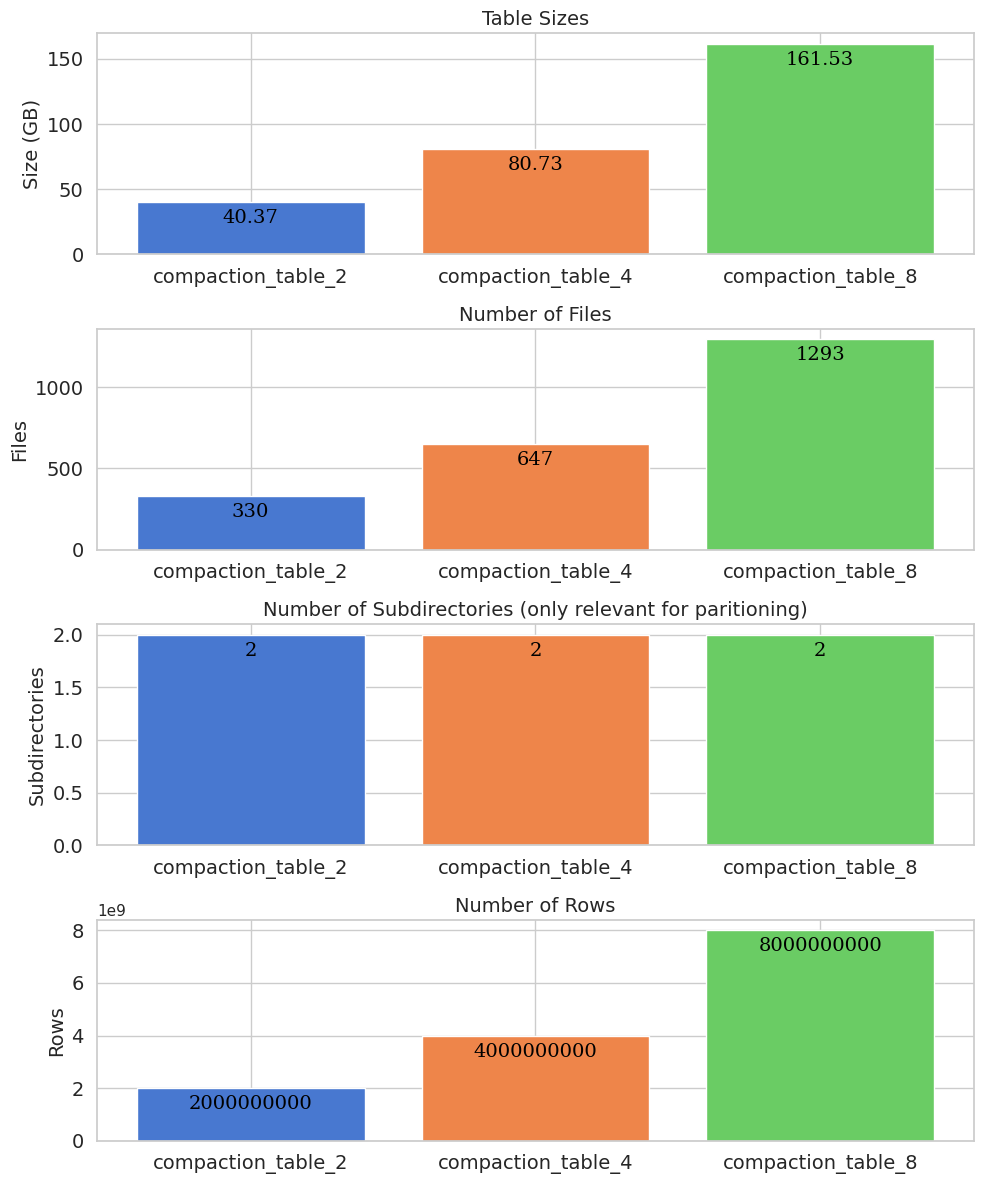

In [58]:
analyze_table_details(spark, tables)

In [74]:
from delta.tables import DeltaTable

delta_table_path = "hdfs://192.168.0.144:9000/datalake/compaction/compaction_table_2"

delta_table = DeltaTable.forPath(spark, delta_table_path)
snapshot = delta_table.toDF()
min_max_stats = snapshot.describe()
print(min_max_stats)
min_max_stats.show(min_max_stats.count(), truncate=False)

5


+-------+----------------------+----------+------------------+----------------+------------------+-----------------+--------------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|summary|value                 |country   |event_id          |actor_id        |year              |month            |day                 |product_id       |location_id      |department_id    |campaign_id      |customer_id      |
+-------+----------------------+----------+------------------+----------------+------------------+-----------------+--------------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|count  |2000000000            |2000000000|2000000000        |2000000000      |2000000000        |2000000000       |2000000000          |2000000000       |2000000000       |2000000000       |2000000000       |2000000000       |
|mean   |0.49998801712566693   |NULL      |500011.179242021  |4999.4672511015 |2026.6854

In [79]:
import json
from pyspark.sql import Row
import pandas as pd


file_path = "hdfs://192.168.0.144:9000/datalake/compaction/compaction_table_2/_delta_log/00000000000000000001.json"

df = spark.read.text(file_path)

rows = []

columns = ["timestamp", "value", "country", "event_id", "actor_id", 
           "year", "month", "day", "product_id", "location_id", 
           "department_id", "campaign_id", "customer_id"]

for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])

        min_values = {f"min_{col}": stats['minValues'].get(col) for col in columns}
        max_values = {f"max_{col}": stats['maxValues'].get(col) for col in columns}

        row_data = {"path": path}
        row_data.update(min_values)
        row_data.update(max_values)
        rows.append(Row(**row_data))

result_df = spark.createDataFrame(rows)

pdf = result_df.toPandas() #Used for aesthetic reasons only
pd.set_option('display.max_columns', None) 
pd.set_option('display.expand_frame_repr', False)  
display(pdf)

,path,min_timestamp,min_value,min_country,min_event_id,min_actor_id,min_year,min_month,min_day,min_product_id,min_location_id,min_department_id,min_campaign_id,min_customer_id,max_timestamp,max_value,max_country,max_event_id,max_actor_id,max_year,max_month,max_day,max_product_id,max_location_id,max_department_id,max_campaign_id,max_customer_id
0,part-00000-373df4b4-6cec-423e-b4a6-10c1eb47d79...,2024-06-03T09:42:13.300Z,9.707343e-08,Argentina,0,0,2024,202406,20240603,1,1,1,1,1,2024-06-10T14:12:23.200Z,1.0,Vietnam,999999,9999,2024,202406,20240610,10,10,10,10,10
1,part-00001-c51420cc-f6ca-4f8a-b487-8cbf0d40224...,2024-06-10T14:12:23.300Z,1.184069e-07,Argentina,0,0,2024,202406,20240610,1,1,1,1,1,2024-06-17T18:09:13.200Z,1.0,Vietnam,999999,9999,2024,202406,20240617,10,10,10,10,10
2,part-00002-8f6504f8-4be0-4f1a-9efb-a886f876c69...,2024-06-17T18:09:13.300Z,2.556501e-07,Argentina,0,0,2024,202406,20240617,1,1,1,1,1,2024-06-24T22:06:03.200Z,1.0,Vietnam,999999,9999,2024,202406,20240624,10,10,10,10,10
3,part-00003-edfedc7d-3e71-4f35-9f09-3d174c9bbcf...,2024-06-24T22:06:03.300Z,4.016681e-08,Argentina,0,0,2024,202406,20240624,1,1,1,1,1,2024-07-02T02:36:13.200Z,1.0,Vietnam,999999,9999,2024,202407,20240702,10,10,10,10,10
4,part-00004-bd485084-14c5-4cbf-a89f-0bd030affe7...,2024-07-02T02:36:13.300Z,1.052573e-07,Argentina,0,0,2024,202407,20240702,1,1,1,1,1,2024-07-09T06:33:03.200Z,1.0,Vietnam,999999,9999,2024,202407,20240709,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,part-00325-27435d01-6edd-4847-bf45-562d869178a...,2024-05-30T16:46:50.000Z,3.424746e-07,Argentina,0,0,2024,202405,20240530,1,1,1,1,1,2024-06-03T09:42:13.200Z,1.0,Vietnam,999999,9999,2024,202406,20240603,10,10,10,10,10
326,part-00326-710330f2-ef3f-4591-8877-c8c66312045...,2029-06-25T13:13:30.000Z,3.297910e-07,Argentina,2,0,2029,202906,20290625,1,1,1,1,1,2029-06-29T06:08:53.200Z,1.0,Vietnam,999999,9999,2029,202906,20290629,10,10,10,10,10
327,part-00327-bf09d9a1-af15-4d65-b033-321a78876fd...,2024-11-01T00:29:03.300Z,2.474137e-07,Argentina,0,0,2024,202411,20241101,1,1,1,1,1,2024-11-04T17:24:26.500Z,1.0,Vietnam,999999,9999,2024,202411,20241104,10,10,10,10,10
328,part-00328-9ca521d7-42f1-42dc-a96d-d94592ae607...,2028-03-19T14:06:50.000Z,2.411740e-07,Argentina,0,0,2028,202803,20280319,1,1,1,1,1,2028-03-23T07:02:13.200Z,1.0,Vietnam,999999,9999,2028,202803,20280323,10,10,10,10,10


In [15]:
spark.sql("show tables").show(truncate=False)

+----------+------------------+-----------+
|namespace |tableName         |isTemporary|
+----------+------------------+-----------+
|compaction|compaction_table_2|false      |
|compaction|compaction_table_4|false      |
|compaction|compaction_table_8|false      |
+----------+------------------+-----------+



In [3]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


num_executions = 10
tables = [
    'compaction_table_2',
    'compaction_table_4',
    'compaction_table_8'
]

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

def get_average_execution_times(query_template, num_executions, tables):
    execution_times = {table: [] for table in tables}
    for table in tables:
        for _ in range(num_executions):
            query = query_template.format(table=table)
            try:
                execution_time = measure_execution_time(query)
                print(f"{table}: {execution_time} seconds")
                execution_times[table].append(execution_time)
            except Exception as e:
                print(f"Error for table {table}: {e}")
    average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}
    return average_times

query1_template = """
SELECT
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country,
    COUNT({table}.event_id) AS event_count
FROM
    {table}
JOIN
    raw_data.product_dim ON {table}.product_id = raw_data.product_dim.product_id
JOIN
    raw_data.location_dim ON {table}.location_id = raw_data.location_dim.location_id
WHERE
    {table}.event_id BETWEEN 459999 AND 999999  
    AND {table}.actor_id IN (5001, 5002, 5003)  
GROUP BY
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country
ORDER BY
    total_value DESC;
"""

query2_template = """
SELECT
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country,
    avg({table}.value) AS total_value
FROM
    {table}
JOIN
    raw_data.product_dim ON {table}.product_id = raw_data.product_dim.product_id
JOIN
    raw_data.location_dim ON {table}.location_id = raw_data.location_dim.location_id
WHERE
    {table}.event_id BETWEEN 459999 AND 999999  
    AND {table}.actor_id IN (5001, 5002, 5003)  
GROUP BY
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country
ORDER BY
    total_value DESC;
"""

In [ ]:
average_times_query1_before = get_average_execution_times(query1_template, num_executions)
average_times_query2_before = get_average_execution_times(query2_template, num_executions)

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393476|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983108|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609752|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333423|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552859|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272953001|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536635|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546518|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393474|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983125|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609756|      32430|
|   Product I|      Dallas|   TX|    USA| 16214.70081633341|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552851|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272953001|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353663|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546511|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393476|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098312|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883313|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609752|      32430|
|   Product I|      Dallas|   TX|    USA| 16214.70081633342|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552857|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725014|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272953001|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454652|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393476|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983126|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883305|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609762|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552859|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725005|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952998|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393477|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983121|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883303|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609769|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552857|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725001|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952994|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536635|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546508|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393457|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098311|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333423|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552859|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725005|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536632|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546517|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393477|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983123|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883293|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609754|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333416|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552859|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272953001|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536628|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546522|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393472|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098312|      32449|
|   Product F|Philadelphia|   PA|    USA| 16259.04758088331|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609756|      32430|
|   Product I|      Dallas|   TX|    USA| 16214.70081633342|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552853|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272953001|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983125|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883296|      32521|
|   Product H|   San Diego|   CA|    USA| 16238.37785360975|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552857|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952994|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546502|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393474|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983123|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609762|      32430|
|   Product I|      Dallas|   TX|    USA| 16214.70081633341|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552859|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA|   16115.736272953|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536634|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804071|      65019|
|   Product F|Philadelphia|   PA|    USA| 32505.90435761466|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205584|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678723|      64775|
|   Product C|     Chicago|   IL|    USA| 32414.75773356102|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691804|      64856|
|   Product J|    San Jose|   CA|    USA|    32261.38152139|      64522|
|   Product G| San Antonio|   TX|    USA| 32260.08499565634|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212636|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214682|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|32562.846448040735|      65019|
|   Product F|Philadelphia|   PA|    USA| 32505.90435761467|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055847|      64944|
|   Product B| Los Angeles|   CA|    USA| 32439.40504667874|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561022|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691815|      64856|
|   Product J|    San Jose|   CA|    USA| 32261.38152139002|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656365|      64622|
|   Product E|     Phoenix|   AZ|    USA| 32179.81861421263|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214708|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804076|      65019|
|   Product F|Philadelphia|   PA|    USA| 32505.90435761467|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205585|      64944|
|   Product B| Los Angeles|   CA|    USA| 32439.40504667871|      64775|
|   Product C|     Chicago|   IL|    USA| 32414.75773356102|      64872|
|   Product H|   San Diego|   CA|    USA| 32358.99064869178|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390023|      64522|
|   Product G| San Antonio|   TX|    USA| 32260.08499565637|      64622|
|   Product E|     Phoenix|   AZ|    USA| 32179.81861421266|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214693|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804073|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614643|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055847|      64944|
|   Product B| Los Angeles|   CA|    USA| 32439.40504667875|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561026|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691783|      64856|
|   Product J|    San Jose|   CA|    USA|    32261.38152139|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656376|      64622|
|   Product E|     Phoenix|   AZ|    USA| 32179.81861421265|      64419|
|   Product I|      Dallas|   TX|    USA| 32112.47699721467|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|32562.846448040764|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614647|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055858|      64944|
|   Product B| Los Angeles|   CA|    USA| 32439.40504667872|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561026|      64872|
|   Product H|   San Diego|   CA|    USA| 32358.99064869181|      64856|
|   Product J|    San Jose|   CA|    USA| 32261.38152139002|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656372|      64622|
|   Product E|     Phoenix|   AZ|    USA| 32179.81861421265|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214682|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804073|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614672|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205588|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678716|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733560993|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691826|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390023|      64522|
|   Product G| San Antonio|   TX|    USA| 32260.08499565637|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212643|      64419|
|   Product I|      Dallas|   TX|    USA| 32112.47699721471|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804072|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614672|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055873|      64944|
|   Product B| Los Angeles|   CA|    USA| 32439.40504667871|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561008|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691815|      64856|
|   Product J|    San Jose|   CA|    USA| 32261.38152139002|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656376|      64622|
|   Product E|     Phoenix|   AZ|    USA| 32179.81861421265|      64419|
|   Product I|      Dallas|   TX|    USA| 32112.47699721468|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|32562.846448040746|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614712|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055844|      64944|
|   Product B| Los Angeles|   CA|    USA| 32439.40504667878|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561004|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691837|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390012|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656354|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212647|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214693|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804073|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614654|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205586|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678734|      64775|
|   Product C|     Chicago|   IL|    USA| 32414.75773356103|      64872|
|   Product H|   San Diego|   CA|    USA| 32358.99064869178|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390027|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656358|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212658|      64419|
|   Product I|      Dallas|   TX|    USA|  32112.4769972147|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804074|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614625|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055858|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678694|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561033|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691815|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390034|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656358|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212632|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214722|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371724|     129858|
|   Product H|   San Diego|   CA|    USA|65025.955152427225|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175055|     129584|
|   Product D|     Houston|   TX|    USA|64751.896070279145|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989626|     129489|
|   Product F|Philadelphia|   PA|    USA|64700.051403774705|     129374|
|   Product B| Los Angeles|   CA|    USA|64590.336909412756|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235443|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623048|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083317|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371724|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242724|     129806|
|   Product I|      Dallas|   TX|    USA|  64772.6387211751|     129584|
|   Product D|     Houston|   TX|    USA|64751.896070279196|     129594|
|   Product C|     Chicago|   IL|    USA|64710.993549896404|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377478|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941274|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235438|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623043|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083313|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371724|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242722|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175055|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027912|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989635|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377471|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941274|     129185|
|   Product J|    San Jose|   CA|    USA|  64539.4306923545|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230546|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083313|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371722|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242729|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117501|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027921|     129594|
|   Product C|     Chicago|   IL|    USA|64710.993549896324|     129489|
|   Product F|Philadelphia|   PA|    USA|  64700.0514037747|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941279|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354435|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623044|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083315|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371731|     129858|
|   Product H|   San Diego|   CA|    USA|  65025.9551524273|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117498|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027918|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989635|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377477|     129374|
|   Product B| Los Angeles|   CA|    USA|64590.336909412756|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235445|     129137|
|   Product A|    New York|   NY|    USA|  64461.4382962304|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083318|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA|65068.694503717255|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242724|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117504|     129584|
|   Product D|     Houston|   TX|    USA|64751.896070279196|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989633|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377476|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941272|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235436|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623049|     129076|
|   Product G| San Antonio|   TX|    USA|64429.902800833144|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371733|     129858|
|   Product H|   San Diego|   CA|    USA|65025.955152427174|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175026|     129584|
|   Product D|     Houston|   TX|    USA|64751.896070279276|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989637|     129489|
|   Product F|Philadelphia|   PA|    USA|64700.051403774785|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941264|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235442|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623053|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083313|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA|65068.694503717255|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242725|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175026|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027918|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989632|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377478|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941272|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235441|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230444|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083317|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371731|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242719|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117501|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027919|     129594|
|   Product C|     Chicago|   IL|    USA|64710.993549896426|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377475|     129374|
|   Product B| Los Angeles|   CA|    USA|64590.336909412785|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235445|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623047|     129076|
|   Product G| San Antonio|   TX|    USA|64429.902800833166|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA|  65068.6945037173|     129858|
|   Product H|   San Diego|   CA|    USA|  65025.9551524272|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117498|     129584|
|   Product D|     Houston|   TX|    USA|64751.896070279196|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989626|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377474|     129374|
|   Product B| Los Angeles|   CA|    USA|64590.336909412756|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235439|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623043|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083321|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734485|
|   Product B| Los Angeles|   CA|    USA| 0.5011096474770597|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221759|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183088|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619693|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729887|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367242|
|   Product F|Philadelphia|   PA|    USA|0.49995533903887635|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833571|
|   Product D|     Houston|   TX|    USA|0.49826045859983287|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 187.02007484436035 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734487|
|   Product B| Los Angeles|   CA|    USA|   0.50110964747706|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221757|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183087|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619693|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729884|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367244|
|   Product F|Philadelphia|   PA|    USA|0.49995533903887673|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833571|
|   Product D|     Houston|   TX|    USA|0.49826045859983287|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 184.9601800441742 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734486|
|   Product B| Los Angeles|   CA|    USA|   0.50110964747706|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221756|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183089|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619695|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729886|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367245|
|   Product F|Philadelphia|   PA|    USA|0.49995533903887657|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833573|
|   Product D|     Houston|   TX|    USA|0.49826045859983287|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 187.34701371192932 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734482|
|   Product B| Los Angeles|   CA|    USA|   0.50110964747706|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221755|
|   Product H|   San Diego|   CA|    USA|  0.500720871218309|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619691|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729884|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367247|
|   Product F|Philadelphia|   PA|    USA|0.49995533903887673|
|   Product J|    San Jose|   CA|    USA|0.49965061718335735|
|   Product D|     Houston|   TX|    USA|0.49826045859983303|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 184.58580470085144 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734486|
|   Product B| Los Angeles|   CA|    USA|   0.50110964747706|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221757|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183088|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619693|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729887|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367244|
|   Product F|Philadelphia|   PA|    USA|0.49995533903887646|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833572|
|   Product D|     Houston|   TX|    USA|  0.498260458599833|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 185.6126959323883 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734487|
|   Product B| Los Angeles|   CA|    USA|   0.50110964747706|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221757|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183087|
|   Product G| San Antonio|   TX|    USA|  0.500310912461969|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729883|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367244|
|   Product F|Philadelphia|   PA|    USA| 0.4999553390388768|
|   Product J|    San Jose|   CA|    USA|0.49965061718335735|
|   Product D|     Houston|   TX|    USA|  0.498260458599833|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 185.20278906822205 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734487|
|   Product B| Los Angeles|   CA|    USA| 0.5011096474770598|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221757|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183088|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619691|
|   Product I|      Dallas|   TX|    USA|  0.500222144572989|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367244|
|   Product F|Philadelphia|   PA|    USA|0.49995533903887696|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833575|
|   Product D|     Houston|   TX|    USA|0.49826045859983314|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 186.1910421848297 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734482|
|   Product B| Los Angeles|   CA|    USA| 0.5011096474770598|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221758|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183089|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619693|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729883|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367247|
|   Product F|Philadelphia|   PA|    USA| 0.4999553390388767|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833574|
|   Product D|     Houston|   TX|    USA|0.49826045859983314|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 186.21383237838745 seconds


+------------+------------+-----+-------+------------------+
|product_name|        city|state|country|       total_value|
+------------+------------+-----+-------+------------------+
|   Product A|    New York|   NY|    USA|0.5015558495734486|
|   Product B| Los Angeles|   CA|    USA|0.5011096474770599|
|   Product C|     Chicago|   IL|    USA|0.5008908753221759|
|   Product H|   San Diego|   CA|    USA|0.5007208712183088|
|   Product G| San Antonio|   TX|    USA|0.5003109124619693|
|   Product I|      Dallas|   TX|    USA|0.5002221445729884|
|   Product E|     Phoenix|   AZ|    USA|0.5000374692367249|
|   Product F|Philadelphia|   PA|    USA|0.4999553390388768|
|   Product J|    San Jose|   CA|    USA|0.4996506171833572|
|   Product D|     Houston|   TX|    USA|0.4982604585998331|
+------------+------------+-----+-------+------------------+

compaction_table_2: 185.74970245361328 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734488|
|   Product B| Los Angeles|   CA|    USA| 0.5011096474770603|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221757|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183088|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619692|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729883|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367242|
|   Product F|Philadelphia|   PA|    USA| 0.4999553390388765|
|   Product J|    San Jose|   CA|    USA|0.49965061718335724|
|   Product D|     Houston|   TX|    USA| 0.4982604585998329|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 185.4436628818512 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926841|
|   Product A|    New York|   NY|    USA| 0.5008204747541601|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552874|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434583|
|   Product D|     Houston|   TX|    USA|0.49974756039135015|
|   Product C|     Chicago|   IL|    USA|0.49967255107844727|
|   Product E|     Phoenix|   AZ|    USA|0.49953924485342244|
|   Product G| San Antonio|   TX|    USA| 0.4992121103595737|
|   Product H|   San Diego|   CA|    USA| 0.4989359604152557|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278994|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 370.8997302055359 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926838|
|   Product A|    New York|   NY|    USA| 0.5008204747541595|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552868|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434585|
|   Product D|     Houston|   TX|    USA| 0.4997475603913503|
|   Product C|     Chicago|   IL|    USA| 0.4996725510784468|
|   Product E|     Phoenix|   AZ|    USA| 0.4995392448534228|
|   Product G| San Antonio|   TX|    USA|0.49921211035957347|
|   Product H|   San Diego|   CA|    USA| 0.4989359604152555|
|   Product I|      Dallas|   TX|    USA|0.49739745352789955|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 371.1241762638092 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926838|
|   Product A|    New York|   NY|    USA| 0.5008204747541601|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552867|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434583|
|   Product D|     Houston|   TX|    USA| 0.4997475603913505|
|   Product C|     Chicago|   IL|    USA|0.49967255107844694|
|   Product E|     Phoenix|   AZ|    USA| 0.4995392448534231|
|   Product G| San Antonio|   TX|    USA| 0.4992121103595732|
|   Product H|   San Diego|   CA|    USA|0.49893596041525545|
|   Product I|      Dallas|   TX|    USA|0.49739745352789905|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 368.49764251708984 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA|  0.502200076592684|
|   Product A|    New York|   NY|    USA| 0.5008204747541601|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552874|
|   Product J|    San Jose|   CA|    USA|  0.500005913043459|
|   Product D|     Houston|   TX|    USA| 0.4997475603913504|
|   Product C|     Chicago|   IL|    USA| 0.4996725510784469|
|   Product E|     Phoenix|   AZ|    USA|0.49953924485342316|
|   Product G| San Antonio|   TX|    USA| 0.4992121103595735|
|   Product H|   San Diego|   CA|    USA|0.49893596041525545|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278995|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 370.5589301586151 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA|  0.502200076592684|
|   Product A|    New York|   NY|    USA| 0.5008204747541602|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552876|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434589|
|   Product D|     Houston|   TX|    USA|0.49974756039135027|
|   Product C|     Chicago|   IL|    USA| 0.4996725510784468|
|   Product E|     Phoenix|   AZ|    USA|  0.499539244853423|
|   Product G| San Antonio|   TX|    USA| 0.4992121103595735|
|   Product H|   San Diego|   CA|    USA|0.49893596041525556|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278991|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 368.5308108329773 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926842|
|   Product A|    New York|   NY|    USA| 0.5008204747541601|
|   Product B| Los Angeles|   CA|    USA|  0.500801312955287|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434584|
|   Product D|     Houston|   TX|    USA|0.49974756039135027|
|   Product C|     Chicago|   IL|    USA|  0.499672551078447|
|   Product E|     Phoenix|   AZ|    USA| 0.4995392448534229|
|   Product G| San Antonio|   TX|    USA| 0.4992121103595738|
|   Product H|   San Diego|   CA|    USA|0.49893596041525584|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278987|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 373.47212266921997 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA|  0.502200076592684|
|   Product A|    New York|   NY|    USA| 0.5008204747541602|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552871|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434582|
|   Product D|     Houston|   TX|    USA|0.49974756039135054|
|   Product C|     Chicago|   IL|    USA| 0.4996725510784469|
|   Product E|     Phoenix|   AZ|    USA|0.49953924485342277|
|   Product G| San Antonio|   TX|    USA|0.49921211035957347|
|   Product H|   San Diego|   CA|    USA|  0.498935960415256|
|   Product I|      Dallas|   TX|    USA|0.49739745352789944|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 372.46784496307373 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926837|
|   Product A|    New York|   NY|    USA| 0.5008204747541599|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552876|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434581|
|   Product D|     Houston|   TX|    USA| 0.4997475603913505|
|   Product C|     Chicago|   IL|    USA|0.49967255107844677|
|   Product E|     Phoenix|   AZ|    USA|0.49953924485342294|
|   Product G| San Antonio|   TX|    USA| 0.4992121103595736|
|   Product H|   San Diego|   CA|    USA| 0.4989359604152551|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278994|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 372.12246584892273 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926841|
|   Product A|    New York|   NY|    USA| 0.5008204747541604|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552871|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434588|
|   Product D|     Houston|   TX|    USA| 0.4997475603913503|
|   Product C|     Chicago|   IL|    USA| 0.4996725510784473|
|   Product E|     Phoenix|   AZ|    USA|0.49953924485342344|
|   Product G| San Antonio|   TX|    USA|0.49921211035957364|
|   Product H|   San Diego|   CA|    USA| 0.4989359604152556|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278993|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 372.60581040382385 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926838|
|   Product A|    New York|   NY|    USA| 0.5008204747541601|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552873|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434585|
|   Product D|     Houston|   TX|    USA|0.49974756039135065|
|   Product C|     Chicago|   IL|    USA|  0.499672551078447|
|   Product E|     Phoenix|   AZ|    USA|0.49953924485342305|
|   Product G| San Antonio|   TX|    USA|0.49921211035957347|
|   Product H|   San Diego|   CA|    USA| 0.4989359604152557|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278993|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 373.58969354629517 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535001|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121168|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954076|
|   Product B| Los Angeles|   CA|    USA| 0.4999832558688143|
|   Product I|      Dallas|   TX|    USA|0.49985058897066803|
|   Product J|    San Jose|   CA|    USA| 0.4997748955942481|
|   Product C|     Chicago|   IL|    USA|0.49974124095402944|
|   Product D|     Houston|   TX|    USA|0.49965195973794463|
|   Product G| San Antonio|   TX|    USA| 0.4994101541006502|
|   Product A|    New York|   NY|    USA| 0.4994068478743569|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 748.2714765071869 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535005|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121169|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954081|
|   Product B| Los Angeles|   CA|    USA| 0.4999832558688136|
|   Product I|      Dallas|   TX|    USA| 0.4998505889706683|
|   Product J|    San Jose|   CA|    USA| 0.4997748955942486|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540297|
|   Product D|     Houston|   TX|    USA|0.49965195973794474|
|   Product G| San Antonio|   TX|    USA|0.49941015410065076|
|   Product A|    New York|   NY|    USA|0.49940684787435735|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 752.1638038158417 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA|  0.501075748153501|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121163|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954085|
|   Product B| Los Angeles|   CA|    USA| 0.4999832558688142|
|   Product I|      Dallas|   TX|    USA|  0.499850588970668|
|   Product J|    San Jose|   CA|    USA| 0.4997748955942477|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540292|
|   Product D|     Houston|   TX|    USA|  0.499651959737945|
|   Product G| San Antonio|   TX|    USA|0.49941015410065087|
|   Product A|    New York|   NY|    USA| 0.4994068478743568|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 749.9576268196106 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535011|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121169|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954077|
|   Product B| Los Angeles|   CA|    USA| 0.4999832558688135|
|   Product I|      Dallas|   TX|    USA| 0.4998505889706681|
|   Product J|    San Jose|   CA|    USA|0.49977489559424887|
|   Product C|     Chicago|   IL|    USA|0.49974124095402944|
|   Product D|     Houston|   TX|    USA|0.49965195973794485|
|   Product G| San Antonio|   TX|    USA|0.49941015410065076|
|   Product A|    New York|   NY|    USA| 0.4994068478743566|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 755.8517382144928 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535004|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121169|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954083|
|   Product B| Los Angeles|   CA|    USA|0.49998325586881426|
|   Product I|      Dallas|   TX|    USA| 0.4998505889706684|
|   Product J|    San Jose|   CA|    USA| 0.4997748955942484|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540297|
|   Product D|     Houston|   TX|    USA|0.49965195973794496|
|   Product G| San Antonio|   TX|    USA| 0.4994101541006512|
|   Product A|    New York|   NY|    USA|0.49940684787435663|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 757.5989429950714 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535012|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121164|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954074|
|   Product B| Los Angeles|   CA|    USA| 0.4999832558688137|
|   Product I|      Dallas|   TX|    USA|0.49985058897066814|
|   Product J|    San Jose|   CA|    USA|0.49977489559424854|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540292|
|   Product D|     Houston|   TX|    USA|0.49965195973794485|
|   Product G| San Antonio|   TX|    USA| 0.4994101541006512|
|   Product A|    New York|   NY|    USA|0.49940684787435674|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 762.6583633422852 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535009|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121166|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954082|
|   Product B| Los Angeles|   CA|    USA| 0.4999832558688143|
|   Product I|      Dallas|   TX|    USA|0.49985058897066803|
|   Product J|    San Jose|   CA|    USA|  0.499774895594248|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540295|
|   Product D|     Houston|   TX|    USA|0.49965195973794463|
|   Product G| San Antonio|   TX|    USA|0.49941015410065087|
|   Product A|    New York|   NY|    USA|  0.499406847874357|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 760.6811935901642 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535005|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121169|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954077|
|   Product B| Los Angeles|   CA|    USA| 0.4999832558688142|
|   Product I|      Dallas|   TX|    USA|0.49985058897066714|
|   Product J|    San Jose|   CA|    USA|0.49977489559424787|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540295|
|   Product D|     Houston|   TX|    USA| 0.4996519597379451|
|   Product G| San Antonio|   TX|    USA| 0.4994101541006505|
|   Product A|    New York|   NY|    USA|0.49940684787435724|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 763.1379907131195 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535004|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121163|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954077|
|   Product B| Los Angeles|   CA|    USA|0.49998325586881376|
|   Product I|      Dallas|   TX|    USA| 0.4998505889706678|
|   Product J|    San Jose|   CA|    USA| 0.4997748955942475|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540294|
|   Product D|     Houston|   TX|    USA|0.49965195973794463|
|   Product G| San Antonio|   TX|    USA| 0.4994101541006506|
|   Product A|    New York|   NY|    USA|0.49940684787435674|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 764.6403970718384 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535005|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121171|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954076|
|   Product B| Los Angeles|   CA|    USA|0.49998325586881354|
|   Product I|      Dallas|   TX|    USA| 0.4998505889706683|
|   Product J|    San Jose|   CA|    USA| 0.4997748955942486|
|   Product C|     Chicago|   IL|    USA|0.49974124095402966|
|   Product D|     Houston|   TX|    USA|0.49965195973794474|
|   Product G| San Antonio|   TX|    USA|0.49941015410065076|
|   Product A|    New York|   NY|    USA|0.49940684787435646|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 768.3495759963989 seconds


In [98]:
from delta.tables import DeltaTable

table_paths = [f"{delta_db_path}/{table}" for table in tables]


for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    
    table_name = path.split("/")[-1]
    print(f"Optimizing and compacting table: {table_name}")
    
    %time delta_table_obj.optimize().executeCompaction()


Optimizing and compacting table: compaction_table_2


CPU times: user 341 ms, sys: 366 ms, total: 707 ms
Wall time: 29min 37s
Optimizing and compacting table: compaction_table_4


CPU times: user 702 ms, sys: 794 ms, total: 1.5 s
Wall time: 55min 51s
Optimizing and compacting table: compaction_table_8


CPU times: user 1.51 s, sys: 1.32 s, total: 2.83 s
Wall time: 1h 57min 35s


In [99]:
def vacuum_delta_table(table_path):
    spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
    delta_table_obj = DeltaTable.forPath(spark, table_path)
    delta_table_obj.vacuum(0)

for path in table_paths:
    table_name = path.split("/")[-1]
    print(f"Vaccuum table: {table_name}")
    %time vacuum_delta_table(path)


Vaccuum table: compaction_table_2


Deleted 330 files and directories in a total of 1 directories.
CPU times: user 66.5 ms, sys: 71.9 ms, total: 138 ms
Wall time: 19.8 s
Vaccuum table: compaction_table_4


Deleted 647 files and directories in a total of 1 directories.
CPU times: user 55.1 ms, sys: 90.7 ms, total: 146 ms
Wall time: 20.4 s
Vaccuum table: compaction_table_8


Deleted 1307 files and directories in a total of 1 directories.
CPU times: user 32.3 ms, sys: 167 ms, total: 199 ms
Wall time: 19 s


In [17]:
average_times_query1_after = get_average_execution_times(query1_template, 2)
average_times_query2_after = get_average_execution_times(query2_template, 2)

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546518|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883296|      32521|
|   Product H|   San Diego|   CA|    USA| 16238.37785360975|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333427|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552853|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725016|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272953003|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983123|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883298|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609752|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333412|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552853|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725027|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272953001|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536643|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|32562.846448040702|      65019|
|   Product F|Philadelphia|   PA|    USA| 32505.90435761468|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055818|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678723|      64775|
|   Product C|     Chicago|   IL|    USA| 32414.75773356103|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691823|      64856|
|   Product J|    San Jose|   CA|    USA| 32261.38152139003|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656376|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212618|      64419|
|   Product I|      Dallas|   TX|    USA| 32112.47699721467|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804071|      65019|
|   Product F|Philadelphia|   PA|    USA| 32505.90435761468|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055833|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678705|      64775|
|   Product C|     Chicago|   IL|    USA| 32414.75773356102|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691808|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390034|      64522|
|   Product G| San Antonio|   TX|    USA| 32260.08499565638|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212632|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214704|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371718|     129858|
|   Product H|   San Diego|   CA|    USA|  65025.9551524273|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117505|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027922|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989625|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377479|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941274|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235442|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230524|     129076|
|   Product G| San Antonio|   TX|    USA|64429.902800833195|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371715|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242728|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175004|     129584|
|   Product D|     Houston|   TX|    USA|64751.896070279305|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989625|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377469|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941279|     129185|
|   Product J|    San Jose|   CA|    USA| 64539.43069235444|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623053|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083321|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734489|
|   Product B| Los Angeles|   CA|    USA| 0.5011096474770603|
|   Product C|     Chicago|   IL|    USA|  0.500890875322176|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183088|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619692|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729884|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367249|
|   Product F|Philadelphia|   PA|    USA| 0.4999553390388767|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833576|
|   Product D|     Houston|   TX|    USA|0.49826045859983287|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 150.6690638065338 seconds


+------------+------------+-----+-------+------------------+
|product_name|        city|state|country|       total_value|
+------------+------------+-----+-------+------------------+
|   Product A|    New York|   NY|    USA|0.5015558495734488|
|   Product B| Los Angeles|   CA|    USA|  0.50110964747706|
|   Product C|     Chicago|   IL|    USA|0.5008908753221759|
|   Product H|   San Diego|   CA|    USA|0.5007208712183087|
|   Product G| San Antonio|   TX|    USA|0.5003109124619691|
|   Product I|      Dallas|   TX|    USA|0.5002221445729885|
|   Product E|     Phoenix|   AZ|    USA|0.5000374692367247|
|   Product F|Philadelphia|   PA|    USA|0.4999553390388765|
|   Product J|    San Jose|   CA|    USA|0.4996506171833574|
|   Product D|     Houston|   TX|    USA|0.4982604585998329|
+------------+------------+-----+-------+------------------+

compaction_table_2: 150.30474376678467 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926845|
|   Product A|    New York|   NY|    USA| 0.5008204747541597|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552871|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434585|
|   Product D|     Houston|   TX|    USA| 0.4997475603913502|
|   Product C|     Chicago|   IL|    USA|0.49967255107844755|
|   Product E|     Phoenix|   AZ|    USA| 0.4995392448534224|
|   Product G| San Antonio|   TX|    USA| 0.4992121103595734|
|   Product H|   San Diego|   CA|    USA| 0.4989359604152553|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278991|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 306.0120196342468 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926843|
|   Product A|    New York|   NY|    USA| 0.5008204747541597|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552867|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434583|
|   Product D|     Houston|   TX|    USA|0.49974756039135015|
|   Product C|     Chicago|   IL|    USA| 0.4996725510784476|
|   Product E|     Phoenix|   AZ|    USA|0.49953924485342277|
|   Product G| San Antonio|   TX|    USA|0.49921211035957336|
|   Product H|   San Diego|   CA|    USA|0.49893596041525556|
|   Product I|      Dallas|   TX|    USA|0.49739745352789877|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 306.8354284763336 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535005|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121166|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954086|
|   Product B| Los Angeles|   CA|    USA|0.49998325586881415|
|   Product I|      Dallas|   TX|    USA|0.49985058897066775|
|   Product J|    San Jose|   CA|    USA| 0.4997748955942485|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540292|
|   Product D|     Houston|   TX|    USA| 0.4996519597379448|
|   Product G| San Antonio|   TX|    USA| 0.4994101541006516|
|   Product A|    New York|   NY|    USA|0.49940684787435735|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 618.7951924800873 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535002|
|   Product H|   San Diego|   CA|    USA|  0.500947222412117|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954076|
|   Product B| Los Angeles|   CA|    USA| 0.4999832558688143|
|   Product I|      Dallas|   TX|    USA| 0.4998505889706678|
|   Product J|    San Jose|   CA|    USA|0.49977489559424815|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540285|
|   Product D|     Houston|   TX|    USA|0.49965195973794474|
|   Product G| San Antonio|   TX|    USA| 0.4994101541006515|
|   Product A|    New York|   NY|    USA| 0.4994068478743574|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 628.8280990123749 seconds


In [18]:
average_times_query1_before = {
    'compaction_table_2': 174.38213882142594,
    'compaction_table_4': 347.23601806623976,
    'compaction_table_8': 722.3862409825342
}

average_times_query2_before = {
    'compaction_table_2': 186.1767604855969,
    'compaction_table_4': 371.2667812675285,
    'compaction_table_8': 758.3741615583618
}
average_times_query1_after = {
    'compaction_table_2': 138.78492534160614,
    'compaction_table_4': 281.8566974401474,
    'compaction_table_8': 580.7429529428482
}
average_times_query2_after = {
    'compaction_table_2': 150.48690378665924,
    'compaction_table_4': 306.4237240552902,
    'compaction_table_8': 623.8116457462311
}
percentage_differences_query1 = {
    'compaction_table_2': -20.40,
    'compaction_table_4': -18.85,
    'compaction_table_8': -19.58
}

percentage_differences_query2 = {
    'compaction_table_2': -19.18,
    'compaction_table_4': -17.49,
    'compaction_table_8': -17.73
}


In [100]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt




def plot_comparison(before_times, after_times, query_num):
    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})

    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Partitioning"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Partitioning"])
    df = df_before.merge(df_after, on="Table")

    ax = df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Partitioningkey {query_num})')
    plt.xticks(rotation=0)
    
    # Set y-axis limit to 500
    plt.ylim(0, 370)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0, 1), prop={'size': 12})  # Fine-tune the position

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height * 1.01),  # Center and slightly above the bar
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'part_table_performance_{query_num}.png', dpi=500)
    plt.show()

def plot_comparison(before_times, after_times, query_num):
    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After"])
    df = df_before.merge(df_after, on="Table")

    df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.xlabel('Table Name')
    plt.ylabel('Average Execution Time (seconds)')
    plt.title(f'Average Query Execution Time for Each Table (Query {query_num})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'compaction_table_performance_{query_num}.png', dpi=400)
    plt.show()

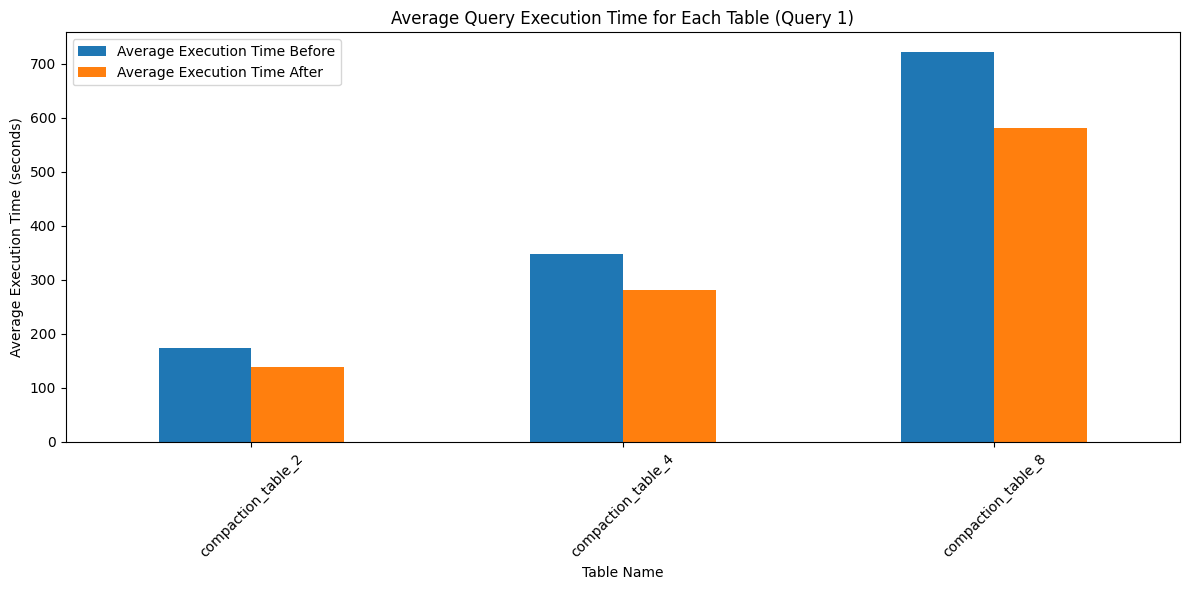

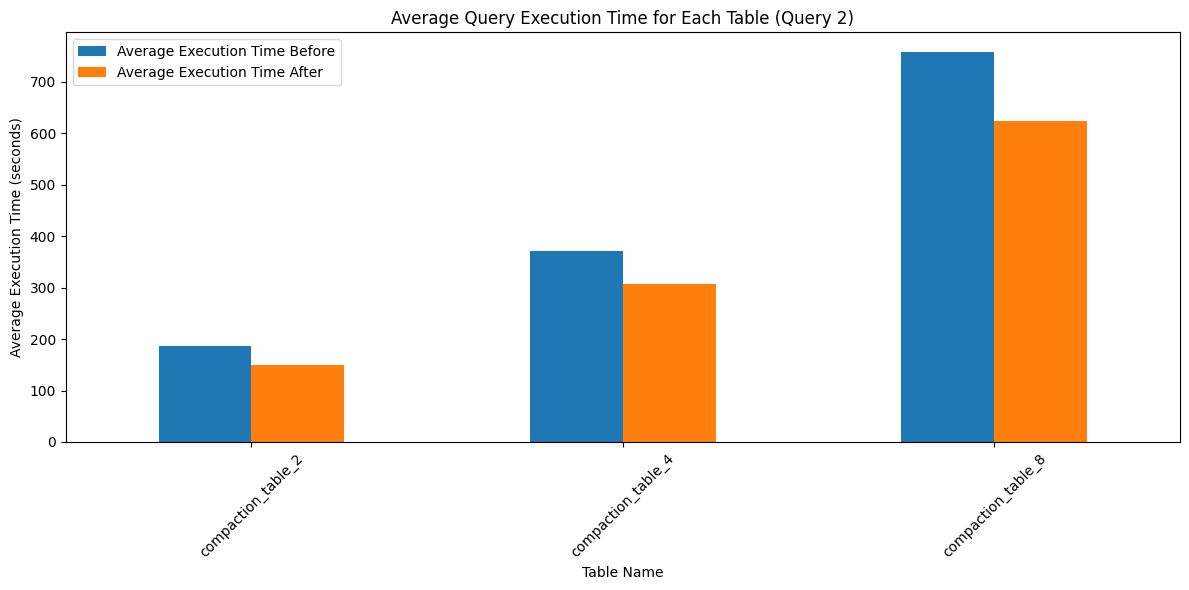

In [ ]:
plot_comparison(average_times_query1_before, average_times_query1_after, 1)
plot_comparison(average_times_query2_before, average_times_query2_after, 2)

Table: compaction_table_2, HDFS Directory: hdfs://192.168.0.144:9000/datalake/compaction/compaction_table_2, Size: 40.38 GB, Number of Files: 43, Partition Columns: [], Subdirectories: 2, Number of Rows: 2000000000
Table: compaction_table_4, HDFS Directory: hdfs://192.168.0.144:9000/datalake/compaction/compaction_table_4, Size: 80.76 GB, Number of Files: 85, Partition Columns: [], Subdirectories: 2, Number of Rows: 4000000000
Table: compaction_table_8, HDFS Directory: hdfs://192.168.0.144:9000/datalake/compaction/compaction_table_8, Size: 161.52 GB, Number of Files: 170, Partition Columns: [], Subdirectories: 2, Number of Rows: 8000000000


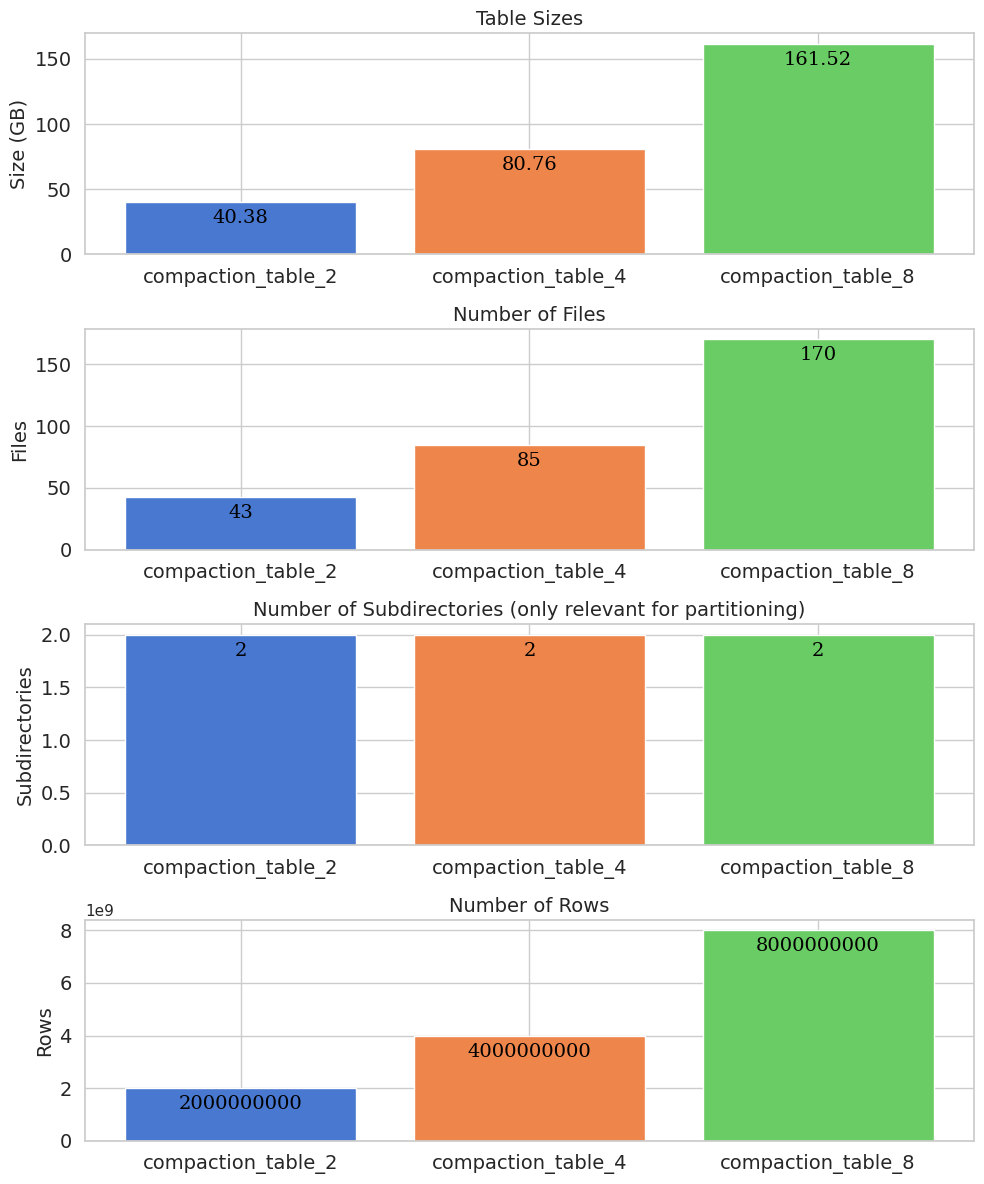

In [25]:
analyze_table_details(spark, tables)

In [26]:
from pyspark.sql import SparkSession
from py4j.java_gateway import java_import

java_import(spark._jvm, "org.apache.hadoop.fs.FileSystem")
java_import(spark._jvm, "org.apache.hadoop.fs.Path")

def list_hdfs_directory(hdfs_path, level=0):
    hadoop_conf = spark._jsc.hadoopConfiguration()
    fs = spark._jvm.FileSystem.get(hadoop_conf)
    path = spark._jvm.Path(hdfs_path)
    
    if level == 0:
        print(f"Listing contents of: {hdfs_path}")
    
    status = fs.listStatus(path)
    
    for file_status in status:
        file_path = file_status.getPath()
        is_dir = file_status.isDirectory()
        size = file_status.getLen() if not is_dir else 0
        indent = ' ' * (level * 2)
        if is_dir:
            print(f"{indent}- {file_path.getName()}/")
            list_hdfs_directory(file_path.toString(), level + 1)
        else:
            size_mb = size / (1024 * 1024)
            print(f"{indent}- {file_path.getName()} ({size_mb:.2f} MB)")

list_hdfs_directory(delta_db_path)

Listing contents of: hdfs://192.168.0.144:9000/datalake/compaction
- compaction_table_2/
  - _delta_log/
    - 00000000000000000000.json (0.00 MB)
    - 00000000000000000001.json (0.32 MB)
    - 00000000000000000002.json (0.12 MB)
    - 00000000000000000003.json (0.00 MB)
    - 00000000000000000004.json (0.00 MB)
    - _commits/
  - part-00000-0165e286-f16d-46fe-b23b-f8f4824ddc51-c000.snappy.parquet (898.88 MB)
  - part-00000-03950109-9e5d-4fe3-863d-cc9cf5b00df4-c000.snappy.parquet (1023.72 MB)
  - part-00000-06a482fb-90f3-442f-aa43-a0ba8ccd1f0b-c000.snappy.parquet (1023.73 MB)
  - part-00000-13dde761-927e-49ec-902e-1c423eff1d2e-c000.snappy.parquet (1023.73 MB)
  - part-00000-2e1e89d7-718f-4805-ae2f-7ed06f0ac0b3-c000.snappy.parquet (898.88 MB)
  - part-00000-2fe74444-2fc8-42f6-a405-fc4702551aa3-c000.snappy.parquet (898.88 MB)
  - part-00000-34590885-2f9b-4203-8079-8fdfd540d68a-c000.snappy.parquet (1023.73 MB)
  - part-00000-4526cef1-9fbe-48fc-b942-37873ecd0775-c000.snappy.parquet (898.

analyze_table_details(spark, tables)

## Creating Table with many files

In [ ]:
import subprocess
import matplotlib.pyplot as plt
import random
from pyspark.sql.functions import lit, rand, expr, year, month, dayofmonth, concat, lpad, element_at, array
from pyspark.sql.types import StringType, StructType, StructField, DateType, TimestampType, DoubleType, LongType, IntegerType
from pyspark.sql import SparkSession
from datetime import datetime, timedelta
import time


#Createing a table with 4000000000 rows
num_tables = 1
max_rows = 456621
num_iterations = 8760

row_counts = [max_rows // (2 ** i) for i in range(num_tables)]

spark.sql("DROP TABLE IF EXISTS compaction_many_files_4")

spark.sql("""
    CREATE TABLE compaction_many_files_4 (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT          
    )
    USING delta;
""")

countries = ["USA", "Canada", "Mexico", "Brazil", "Argentina", "UK", "France", "Germany", "Italy", "Spain",
             "China", "Japan", "South Korea", "India", "Australia", "New Zealand", "South Africa", "Egypt", "Nigeria", "Kenya",
             "Russia", "Turkey", "Saudi Arabia", "Indonesia", "Thailand", "Malaysia", "Philippines", "Vietnam", "Singapore", "Pakistan",
             "Bangladesh", "Sri Lanka", "Nepal", "Bhutan", "Maldives"]

def generate_data(timestamp, nrows):
    date = timestamp.date()
    return spark.range(nrows).select(
        (lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id")).alias("timestamp"),
        rand().alias("value"),
        element_at(array([lit(country) for country in countries]), (rand() * len(countries)).cast("int") + 1).alias("country"),
        (rand() * 1000000).cast("long").alias("event_id"),
        (rand() * 10000).cast("long").alias("actor_id"),
        year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).alias("year"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("month"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0'),
            lpad(dayofmonth((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("day"),
        expr("id % 10 + 1").cast("int").alias("product_id"),
        expr("id % 10 + 1").cast("int").alias("location_id"),
        expr("id % 10 + 1").cast("int").alias("department_id"),
        expr("id % 10 + 1").cast("int").alias("campaign_id"),
        expr("id % 10 + 1").cast("int").alias("customer_id")
    )

timestamp = datetime(2024, 1, 1) 
start_time = time.time()


for iteration in range(num_iterations):
    for i, rows in enumerate(row_counts):
        print(f"Inserting data into table: compaction_many_files_4, iteration: {iteration + 1}/{num_iterations}, row_count: {rows}")
        data_df = generate_data(timestamp, rows)
        data_df.write.format("delta").mode("append").saveAsTable("compaction_many_files_4")   
    timestamp += timedelta(hours=1) 

end_time = time.time()
print(f"Operation completed in {end_time - start_time:.2f} seconds")

[456621]


24/08/01 15:02:35 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`compaction`.`compaction_many_files_4` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/08/01 15:02:35 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


Inserting data into table: compaction_many_files_4, iteration: 1/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 2/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 3/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 4/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 5/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 6/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 7/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 8/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 9/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 10/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 11/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 12/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 13/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 14/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 15/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 16/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 17/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 18/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 19/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 20/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 21/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 22/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 23/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 24/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 25/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 26/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 27/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 28/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 29/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 30/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 31/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 32/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 33/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 34/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 35/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 36/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 37/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 38/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 39/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 40/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 41/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 42/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 43/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 44/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 45/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 46/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 47/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 48/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 49/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 50/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 51/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 52/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 53/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 54/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 55/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 56/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 57/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 58/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 59/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 60/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 61/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 62/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 63/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 64/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 65/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 66/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 67/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 68/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 69/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 70/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 71/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 72/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 73/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 74/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 75/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 76/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 77/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 78/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 79/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 80/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 81/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 82/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 83/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 84/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 85/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 86/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 87/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 88/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 89/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 90/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 91/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 92/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 93/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 94/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 95/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 96/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 97/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 98/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 99/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 100/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 101/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 102/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 103/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 104/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 105/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 106/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 107/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 108/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 109/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 110/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 111/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 112/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 113/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 114/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 115/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 116/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 117/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 118/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 119/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 120/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 121/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 122/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 123/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 124/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 125/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 126/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 127/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 128/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 129/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 130/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 131/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 132/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 133/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 134/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 135/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 136/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 137/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 138/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 139/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 140/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 141/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 142/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 143/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 144/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 145/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 146/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 147/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 148/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 149/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 150/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 151/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 152/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 153/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 154/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 155/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 156/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 157/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 158/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 159/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 160/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 161/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 162/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 163/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 164/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 165/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 166/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 167/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 168/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 169/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 170/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 171/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 172/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 173/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 174/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 175/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 176/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 177/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 178/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 179/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 180/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 181/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 182/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 183/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 184/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 185/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 186/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 187/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 188/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 189/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 190/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 191/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 192/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 193/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 194/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 195/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 196/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 197/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 198/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 199/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 200/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 201/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 202/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 203/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 204/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 205/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 206/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 207/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 208/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 209/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 210/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 211/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 212/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 213/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 214/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 215/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 216/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 217/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 218/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 219/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 220/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 221/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 222/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 223/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 224/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 225/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 226/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 227/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 228/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 229/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 230/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 231/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 232/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 233/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 234/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 235/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 236/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 237/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 238/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 239/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 240/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 241/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 242/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 243/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 244/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 245/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 246/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 247/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 248/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 249/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 250/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 251/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 252/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 253/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 254/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 255/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 256/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 257/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 258/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 259/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 260/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 261/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 262/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 263/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 264/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 265/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 266/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 267/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 268/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 269/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 270/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 271/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 272/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 273/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 274/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 275/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 276/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 277/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 278/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 279/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 280/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 281/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 282/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 283/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 284/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 285/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 286/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 287/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 288/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 289/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 290/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 291/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 292/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 293/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 294/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 295/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 296/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 297/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 298/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 299/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 300/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 301/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 302/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 303/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 304/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 305/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 306/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 307/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 308/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 309/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 310/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 311/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 312/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 313/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 314/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 315/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 316/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 317/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 318/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 319/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 320/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 321/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 322/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 323/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 324/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 325/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 326/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 327/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 328/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 329/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 330/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 331/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 332/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 333/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 334/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 335/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 336/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 337/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 338/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 339/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 340/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 341/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 342/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 343/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 344/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 345/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 346/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 347/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 348/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 349/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 350/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 351/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 352/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 353/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 354/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 355/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 356/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 357/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 358/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 359/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 360/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 361/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 362/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 363/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 364/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 365/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 366/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 367/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 368/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 369/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 370/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 371/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 372/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 373/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 374/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 375/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 376/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 377/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 378/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 379/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 380/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 381/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 382/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 383/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 384/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 385/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 386/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 387/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 388/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 389/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 390/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 391/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 392/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 393/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 394/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 395/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 396/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 397/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 398/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 399/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 400/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 401/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 402/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 403/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 404/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 405/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 406/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 407/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 408/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 409/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 410/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 411/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 412/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 413/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 414/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 415/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 416/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 417/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 418/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 419/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 420/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 421/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 422/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 423/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 424/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 425/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 426/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 427/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 428/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 429/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 430/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 431/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 432/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 433/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 434/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 435/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 436/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 437/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 438/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 439/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 440/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 441/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 442/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 443/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 444/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 445/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 446/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 447/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 448/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 449/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 450/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 451/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 452/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 453/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 454/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 455/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 456/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 457/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 458/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 459/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 460/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 461/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 462/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 463/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 464/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 465/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 466/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 467/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 468/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 469/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 470/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 471/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 472/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 473/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 474/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 475/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 476/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 477/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 478/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 479/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 480/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 481/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 482/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 483/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 484/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 485/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 486/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 487/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 488/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 489/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 490/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 491/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 492/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 493/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 494/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 495/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 496/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 497/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 498/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 499/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 500/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 501/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 502/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 503/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 504/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 505/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 506/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 507/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 508/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 509/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 510/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 511/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 512/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 513/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 514/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 515/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 516/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 517/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 518/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 519/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 520/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 521/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 522/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 523/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 524/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 525/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 526/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 527/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 528/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 529/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 530/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 531/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 532/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 533/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 534/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 535/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 536/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 537/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 538/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 539/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 540/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 541/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 542/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 543/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 544/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 545/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 546/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 547/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 548/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 549/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 550/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 551/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 552/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 553/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 554/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 555/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 556/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 557/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 558/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 559/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 560/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 561/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 562/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 563/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 564/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 565/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 566/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 567/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 568/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 569/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 570/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 571/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 572/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 573/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 574/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 575/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 576/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 577/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 578/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 579/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 580/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 581/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 582/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 583/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 584/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 585/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 586/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 587/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 588/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 589/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 590/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 591/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 592/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 593/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 594/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 595/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 596/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 597/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 598/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 599/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 600/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 601/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 602/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 603/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 604/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 605/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 606/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 607/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 608/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 609/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 610/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 611/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 612/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 613/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 614/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 615/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 616/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 617/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 618/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 619/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 620/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 621/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 622/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 623/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 624/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 625/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 626/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 627/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 628/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 629/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 630/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 631/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 632/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 633/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 634/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 635/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 636/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 637/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 638/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 639/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 640/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 641/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 642/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 643/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 644/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 645/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 646/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 647/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 648/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 649/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 650/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 651/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 652/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 653/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 654/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 655/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 656/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 657/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 658/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 659/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 660/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 661/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 662/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 663/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 664/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 665/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 666/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 667/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 668/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 669/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 670/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 671/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 672/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 673/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 674/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 675/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 676/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 677/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 678/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 679/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 680/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 681/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 682/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 683/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 684/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 685/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 686/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 687/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 688/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 689/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 690/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 691/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 692/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 693/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 694/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 695/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 696/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 697/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 698/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 699/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 700/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 701/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 702/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 703/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 704/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 705/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 706/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 707/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 708/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 709/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 710/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 711/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 712/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 713/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 714/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 715/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 716/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 717/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 718/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 719/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 720/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 721/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 722/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 723/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 724/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 725/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 726/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 727/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 728/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 729/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 730/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 731/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 732/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 733/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 734/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 735/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 736/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 737/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 738/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 739/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 740/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 741/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 742/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 743/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 744/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 745/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 746/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 747/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 748/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 749/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 750/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 751/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 752/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 753/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 754/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 755/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 756/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 757/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 758/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 759/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 760/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 761/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 762/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 763/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 764/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 765/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 766/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 767/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 768/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 769/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 770/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 771/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 772/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 773/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 774/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 775/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 776/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 777/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 778/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 779/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 780/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 781/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 782/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 783/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 784/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 785/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 786/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 787/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 788/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 789/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 790/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 791/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 792/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 793/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 794/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 795/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 796/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 797/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 798/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 799/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 800/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 801/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 802/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 803/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 804/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 805/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 806/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 807/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 808/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 809/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 810/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 811/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 812/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 813/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 814/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 815/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 816/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 817/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 818/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 819/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 820/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 821/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 822/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 823/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 824/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 825/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 826/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 827/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 828/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 829/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 830/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 831/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 832/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 833/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 834/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 835/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 836/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 837/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 838/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 839/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 840/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 841/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 842/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 843/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 844/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 845/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 846/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 847/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 848/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 849/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 850/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 851/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 852/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 853/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 854/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 855/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 856/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 857/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 858/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 859/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 860/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 861/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 862/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 863/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 864/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 865/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 866/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 867/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 868/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 869/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 870/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 871/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 872/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 873/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 874/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 875/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 876/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 877/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 878/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 879/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 880/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 881/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 882/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 883/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 884/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 885/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 886/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 887/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 888/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 889/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 890/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 891/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 892/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 893/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 894/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 895/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 896/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 897/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 898/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 899/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 900/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 901/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 902/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 903/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 904/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 905/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 906/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 907/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 908/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 909/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 910/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 911/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 912/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 913/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 914/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 915/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 916/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 917/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 918/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 919/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 920/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 921/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 922/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 923/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 924/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 925/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 926/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 927/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 928/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 929/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 930/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 931/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 932/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 933/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 934/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 935/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 936/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 937/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 938/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 939/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 940/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 941/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 942/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 943/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 944/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 945/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 946/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 947/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 948/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 949/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 950/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 951/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 952/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 953/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 954/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 955/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 956/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 957/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 958/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 959/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 960/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 961/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 962/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 963/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 964/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 965/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 966/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 967/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 968/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 969/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 970/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 971/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 972/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 973/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 974/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 975/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 976/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 977/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 978/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 979/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 980/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 981/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 982/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 983/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 984/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 985/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 986/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 987/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 988/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 989/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 990/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 991/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 992/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 993/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 994/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 995/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 996/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 997/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 998/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 999/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1000/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1001/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1002/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1003/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1004/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1005/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1006/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1007/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1008/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1009/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1010/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1011/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1012/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1013/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1014/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1015/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1016/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1017/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1018/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1019/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1020/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1021/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1022/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1023/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1024/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1025/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1026/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1027/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1028/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1029/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1030/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1031/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1032/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1033/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1034/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1035/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1036/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1037/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1038/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1039/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1040/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1041/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1042/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1043/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1044/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1045/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1046/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1047/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1048/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1049/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1050/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1051/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1052/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1053/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1054/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1055/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1056/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1057/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1058/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1059/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1060/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1061/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1062/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1063/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1064/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1065/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1066/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1067/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1068/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1069/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1070/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1071/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1072/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1073/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1074/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1075/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1076/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1077/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1078/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1079/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1080/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1081/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1082/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1083/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1084/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1085/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1086/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1087/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1088/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1089/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1090/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1091/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1092/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1093/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1094/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1095/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1096/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1097/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1098/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1099/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1100/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1101/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1102/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1103/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1104/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1105/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1106/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1107/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1108/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1109/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1110/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1111/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1112/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1113/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1114/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1115/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1116/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1117/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1118/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1119/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1120/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1121/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1122/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1123/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1124/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1125/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1126/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1127/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1128/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1129/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1130/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1131/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1132/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1133/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1134/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1135/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1136/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1137/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1138/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1139/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1140/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1141/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1142/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1143/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1144/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1145/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1146/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1147/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1148/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1149/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1150/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1151/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1152/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1153/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1154/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1155/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1156/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1157/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1158/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1159/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1160/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1161/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1162/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1163/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1164/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1165/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1166/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1167/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1168/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1169/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1170/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1171/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1172/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1173/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1174/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1175/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1176/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1177/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1178/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1179/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1180/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1181/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1182/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1183/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1184/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1185/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1186/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1187/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1188/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1189/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1190/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1191/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1192/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1193/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1194/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1195/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1196/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1197/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1198/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1199/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1200/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1201/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1202/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1203/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1204/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1205/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1206/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1207/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1208/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1209/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1210/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1211/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1212/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1213/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1214/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1215/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1216/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1217/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1218/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1219/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1220/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1221/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1222/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1223/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1224/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1225/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1226/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1227/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1228/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1229/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1230/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1231/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1232/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1233/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1234/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1235/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1236/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1237/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1238/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1239/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1240/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1241/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1242/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1243/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1244/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1245/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1246/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1247/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1248/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1249/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1250/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1251/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1252/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1253/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1254/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1255/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1256/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1257/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1258/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1259/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1260/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1261/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1262/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1263/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1264/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1265/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1266/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1267/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1268/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1269/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1270/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1271/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1272/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1273/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1274/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1275/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1276/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1277/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1278/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1279/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1280/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1281/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1282/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1283/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1284/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1285/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1286/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1287/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1288/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1289/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1290/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1291/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1292/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1293/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1294/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1295/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1296/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1297/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1298/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1299/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1300/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1301/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1302/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1303/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1304/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1305/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1306/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1307/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1308/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1309/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1310/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1311/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1312/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1313/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1314/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1315/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1316/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1317/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1318/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1319/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1320/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1321/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1322/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1323/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1324/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1325/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1326/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1327/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1328/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1329/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1330/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1331/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1332/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1333/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1334/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1335/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1336/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1337/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1338/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1339/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1340/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1341/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1342/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1343/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1344/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1345/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1346/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1347/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1348/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1349/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1350/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1351/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1352/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1353/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1354/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1355/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1356/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1357/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1358/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1359/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1360/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1361/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1362/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1363/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1364/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1365/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1366/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1367/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1368/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1369/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1370/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1371/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1372/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1373/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1374/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1375/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1376/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1377/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1378/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1379/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1380/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1381/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1382/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1383/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1384/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1385/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1386/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1387/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1388/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1389/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1390/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1391/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1392/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1393/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1394/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1395/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1396/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1397/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1398/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1399/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1400/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1401/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1402/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1403/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1404/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1405/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1406/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1407/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1408/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1409/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1410/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1411/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1412/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1413/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1414/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1415/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1416/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1417/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1418/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1419/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1420/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1421/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1422/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1423/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1424/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1425/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1426/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1427/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1428/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1429/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1430/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1431/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1432/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1433/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1434/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1435/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1436/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1437/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1438/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1439/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1440/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1441/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1442/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1443/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1444/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1445/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1446/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1447/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1448/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1449/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1450/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1451/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1452/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1453/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1454/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1455/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1456/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1457/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1458/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1459/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1460/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1461/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1462/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1463/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1464/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1465/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1466/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1467/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1468/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1469/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1470/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1471/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1472/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1473/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1474/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1475/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1476/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1477/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1478/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1479/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1480/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1481/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1482/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1483/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1484/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1485/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1486/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1487/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1488/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1489/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1490/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1491/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1492/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1493/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1494/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1495/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1496/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1497/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1498/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1499/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1500/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1501/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1502/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1503/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1504/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1505/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1506/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1507/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1508/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1509/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1510/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1511/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1512/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1513/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1514/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1515/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1516/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1517/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1518/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1519/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1520/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1521/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1522/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1523/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1524/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1525/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1526/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1527/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1528/8760, row_count: 456621
Inserting data into table: compaction_many_files_4, iteration: 1529/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1530/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1531/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1532/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1533/8760, row_count: 456621


Inserting data into table: compaction_many_files_4, iteration: 1534/8760, row_count: 456621


In [8]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType

num_executions = 10
tables = ["compaction_many_files_4"]

average_times_query1_before = get_average_execution_times(query1_template, num_executions, tables)
average_times_query2_before = get_average_execution_times(query2_template, num_executions, tables)


+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product I|      Dallas|   TX|    USA|32718.500007478688|      65210|
|   Product J|    San Jose|   CA|    USA|32619.386518073487|      65159|
|   Product H|   San Diego|   CA|    USA|32592.126543770286|      64952|
|   Product A|    New York|   NY|    USA|  32495.9998042936|      64920|
|   Product C|     Chicago|   IL|    USA| 32458.19408617536|      64880|
|   Product E|     Phoenix|   AZ|    USA|32451.835145653808|      64734|
|   Product D|     Houston|   TX|    USA|32351.876147627194|      64558|
|   Product G| San Antonio|   TX|    USA|32349.204729211637|      64587|
|   Product B| Los Angeles|   CA|    USA|32218.014276565355|      64578|
|   Product F|Philadelphia|   PA|    USA| 32165.64622354642|      64478|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product H|   San Diego|   CA|    USA| 0.5017878824943082|
|   Product I|      Dallas|   TX|    USA| 0.5017405307081529|
|   Product E|     Phoenix|   AZ|    USA| 0.5013105191345177|
|   Product D|     Houston|   TX|    USA| 0.5011288476660847|
|   Product G| San Antonio|   TX|    USA| 0.5008624758730346|
|   Product J|    San Jose|   CA|    USA| 0.5006121413476797|
|   Product A|    New York|   NY|    USA| 0.5005545256360687|
|   Product C|     Chicago|   IL|    USA| 0.5002804267289658|
|   Product B| Los Angeles|   CA|    USA| 0.4989007754431119|
|   Product F|Philadelphia|   PA|    USA|0.49886234411033664|
+------------+------------+-----+-------+-------------------+

compaction_many_files_4: 1117.191398859024 seconds


Table: compaction_many_files_4, HDFS Directory: hdfs://192.168.0.144:9000/datalake/compaction/compaction_many_files_4, Size: 100.53 GB, Number of Files: 131400, Partition Columns: [], Subdirectories: 2, Number of Rows: 3999999960


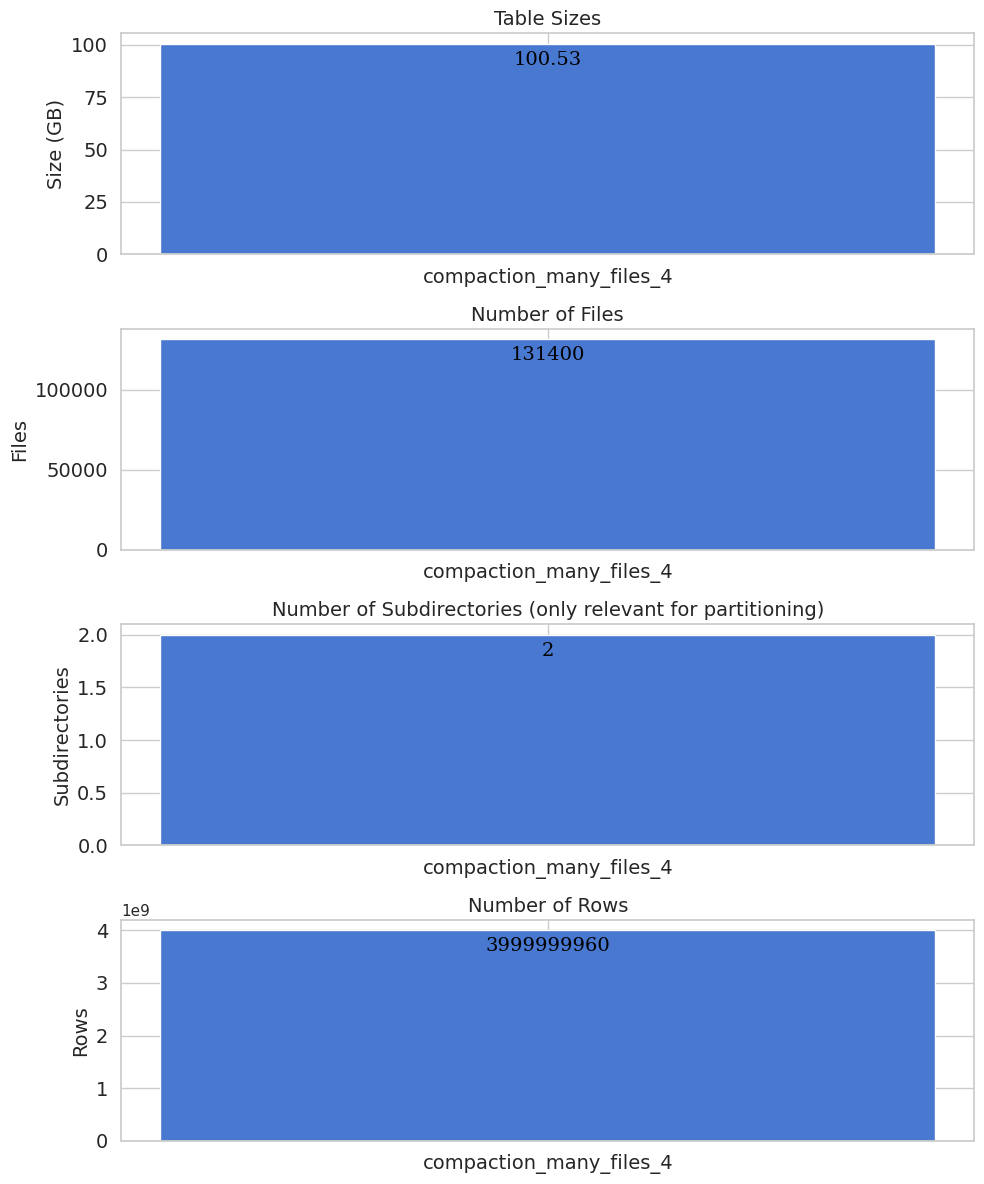

In [11]:
tables = ["compaction_many_files_4"]

analyze_table_details(spark, tables)

In [12]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/compaction/compaction_many_files_4"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    
    table_name = path.split("/")[-1]
    print(f"Optimizing and compacting table: {table_name}")
    
    %time delta_table_obj.optimize().executeCompaction()


Optimizing and compacting table: compaction_many_files_4


CPU times: user 639 ms, sys: 700 ms, total: 1.34 s
Wall time: 46min 20s


In [13]:
average_times_query1_after = get_average_execution_times(query1_template, num_executions, tables)
average_times_query2_after = get_average_execution_times(query2_template, num_executions, tables)

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product I|      Dallas|   TX|    USA|32718.500007478655|      65210|
|   Product J|    San Jose|   CA|    USA|32619.386518073483|      65159|
|   Product H|   San Diego|   CA|    USA|32592.126543770228|      64952|
|   Product A|    New York|   NY|    USA|32495.999804293606|      64920|
|   Product C|     Chicago|   IL|    USA|32458.194086175252|      64880|
|   Product E|     Phoenix|   AZ|    USA| 32451.83514565382|      64734|
|   Product D|     Houston|   TX|    USA| 32351.87614762716|      64558|
|   Product G| San Antonio|   TX|    USA| 32349.20472921169|      64587|
|   Product B| Los Angeles|   CA|    USA|32218.014276565264|      64578|
|   Product F|Philadelphia|   PA|    USA|32165.646223546366|      64478|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product H|   San Diego|   CA|    USA| 0.5017878824943075|
|   Product I|      Dallas|   TX|    USA| 0.5017405307081538|
|   Product E|     Phoenix|   AZ|    USA| 0.5013105191345172|
|   Product D|     Houston|   TX|    USA| 0.5011288476660862|
|   Product G| San Antonio|   TX|    USA| 0.5008624758730351|
|   Product J|    San Jose|   CA|    USA| 0.5006121413476803|
|   Product A|    New York|   NY|    USA|  0.500554525636069|
|   Product C|     Chicago|   IL|    USA| 0.5002804267289652|
|   Product B| Los Angeles|   CA|    USA|  0.498900775443112|
|   Product F|Philadelphia|   PA|    USA|0.49886234411033786|
+------------+------------+-----+-------+-------------------+

compaction_many_files_4: 394.86236667633057 seconds


In [35]:
average_times_query1_before = {
    'small_table\n(2×10^9 rows)': 174.38213882142594,
    'medium_table\n(4×10^9 rows)': 347.23601806623976,
    'big_table\n(8×10^9 rows)': 722.3862409825342,
    'fragmented_table\n(4×10^9 rows)': 1185.76321649551
}

average_times_query1_after = {
    'small_table\n(2×10^9 rows)': 138.78492534160614,
    'medium_table\n(4×10^9 rows)': 281.8566974401474,
    'big_table\n(8×10^9 rows)': 580.7429529428482,
    'fragmented_table\n(4×10^9 rows)': 411.08534026145935
}
average_times_query1_before = {
    'small_table\n($2\\times10^9$ rows)': 174.38213882142594,
    'medium_table\n($4\\times10^9$ rows)': 347.23601806623976,
    'big_table\n($8\\times10^9$ rows)': 722.3862409825342,
    'fragmented_table\n($4\\times10^9$ rows)': 1185.76321649551
}

average_times_query1_after = {
    'small_table\n($2\\times10^9$ rows)': 138.78492534160614,
    'medium_table\n($4\\times10^9$ rows)': 281.8566974401474,
    'big_table\n($8\\times10^9$ rows)': 580.7429529428482,
    'fragmented_table\n($4\\times10^9$ rows)': 411.08534026145935
}

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

def plot_comparison(before_times, after_times, query_num):
    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})

    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Compaction"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Compaction"])
    df = df_before.merge(df_after, on="Table")

    ax = df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Query {query_num})')
    plt.xticks(rotation=0)
    
    plt.ylim(0, 1270)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0, 1), prop={'size': 12})  

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height * 1.01),  
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'compaction_table_performance_{query_num}.png', dpi=500)
    plt.show()



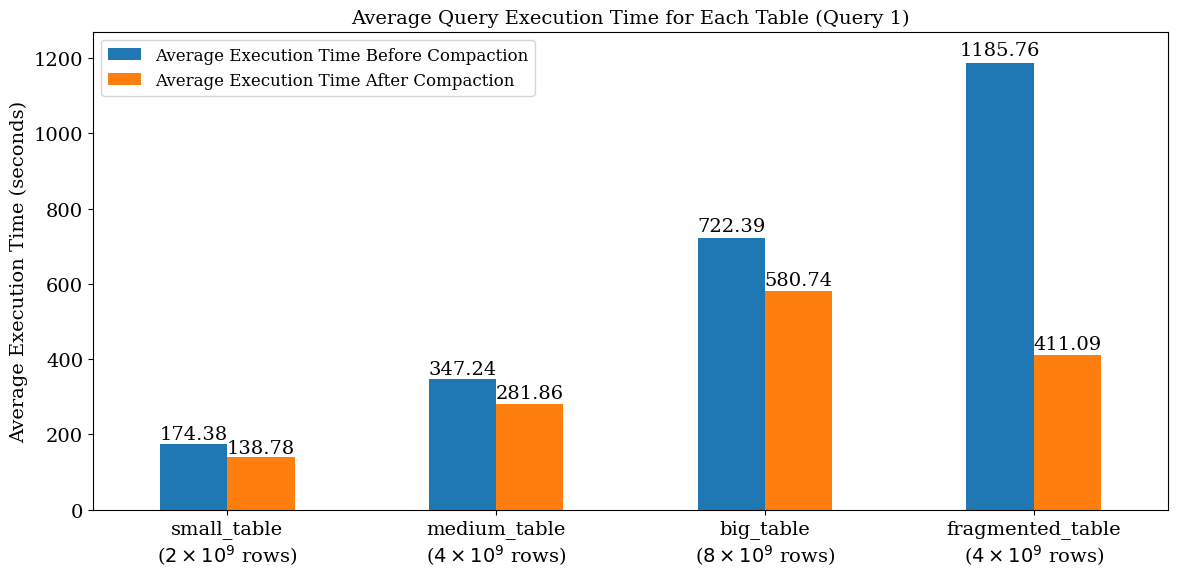

In [43]:
plot_comparison(average_times_query1_before, average_times_query1_after, 1)

In [81]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_2",
    "hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_4",
    "hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_8"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    
    table_name = path.split("/")[-1]
    print(f"Optimizing and compacting table: {table_name}")
    
    %time delta_table_obj.optimize().executeCompaction()

Optimizing and compacting table: raw_data_2


CPU times: user 313 µs, sys: 6.61 ms, total: 6.92 ms
Wall time: 3.26 s
Optimizing and compacting table: raw_data_4
CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 1.3 s
Optimizing and compacting table: raw_data_8
CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.26 s


In [ ]:
table_pairs = [
    ('raw_data.rawdata_8', 'raw_data.raw_data_8'),
    ('raw_data.rawdata_4', 'raw_data.raw_data_4'),
    ('raw_data.rawdata_2', 'raw_data.raw_data_2')
]

In [95]:
average_times_query1_before = get_average_execution_times(query1_template, num_executions, tables)
average_times_query2_before = get_average_execution_times(query2_template, num_executions, tables)

+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product E|     Phoenix|   AZ|    USA|     129858|
|   Product H|   San Diego|   CA|    USA|     129806|
|   Product D|     Houston|   TX|    USA|     129594|
|   Product I|      Dallas|   TX|    USA|     129584|
|   Product C|     Chicago|   IL|    USA|     129489|
|   Product F|Philadelphia|   PA|    USA|     129374|
|   Product B| Los Angeles|   CA|    USA|     129185|
|   Product J|    San Jose|   CA|    USA|     129137|
|   Product A|    New York|   NY|    USA|     129076|
|   Product G| San Antonio|   TX|    USA|     129012|
+------------+------------+-----+-------+-----------+

raw_data.rawdata_8: 356.9127354621887 seconds


+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product A|    New York|   NY|    USA|      65019|
|   Product D|     Houston|   TX|    USA|      64944|
|   Product C|     Chicago|   IL|    USA|      64872|
|   Product H|   San Diego|   CA|    USA|      64856|
|   Product B| Los Angeles|   CA|    USA|      64775|
|   Product F|Philadelphia|   PA|    USA|      64727|
|   Product G| San Antonio|   TX|    USA|      64622|
|   Product I|      Dallas|   TX|    USA|      64561|
|   Product J|    San Jose|   CA|    USA|      64522|
|   Product E|     Phoenix|   AZ|    USA|      64419|
+------------+------------+-----+-------+-----------+

raw_data.rawdata_4: 175.25898122787476 seconds


+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product G| San Antonio|   TX|    USA|      32631|
|   Product F|Philadelphia|   PA|    USA|      32521|
|   Product A|    New York|   NY|    USA|      32485|
|   Product B| Los Angeles|   CA|    USA|      32449|
|   Product J|    San Jose|   CA|    USA|      32434|
|   Product H|   San Diego|   CA|    USA|      32430|
|   Product I|      Dallas|   TX|    USA|      32415|
|   Product C|     Chicago|   IL|    USA|      32367|
|   Product D|     Houston|   TX|    USA|      32344|
|   Product E|     Phoenix|   AZ|    USA|      31985|
+------------+------------+-----+-------+-----------+

raw_data.rawdata_2: 90.70007944107056 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481535005|
|   Product H|   San Diego|   CA|    USA|  0.500947222412117|
|   Product F|Philadelphia|   PA|    USA|  0.500100881195408|
|   Product B| Los Angeles|   CA|    USA|  0.499983255868814|
|   Product I|      Dallas|   TX|    USA|  0.499850588970668|
|   Product J|    San Jose|   CA|    USA| 0.4997748955942474|
|   Product C|     Chicago|   IL|    USA|0.49974124095402966|
|   Product D|     Houston|   TX|    USA|0.49965195973794513|
|   Product G| San Antonio|   TX|    USA|0.49941015410065076|
|   Product A|    New York|   NY|    USA|0.49940684787435696|
+------------+------------+-----+-------+-------------------+

raw_data.rawdata_8: 753.6843919754028 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926837|
|   Product A|    New York|   NY|    USA| 0.5008204747541595|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552874|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434584|
|   Product D|     Houston|   TX|    USA| 0.4997475603913502|
|   Product C|     Chicago|   IL|    USA| 0.4996725510784466|
|   Product E|     Phoenix|   AZ|    USA|0.49953924485342305|
|   Product G| San Antonio|   TX|    USA| 0.4992121103595738|
|   Product H|   San Diego|   CA|    USA| 0.4989359604152559|
|   Product I|      Dallas|   TX|    USA| 0.4973974535278991|
+------------+------------+-----+-------+-------------------+

raw_data.rawdata_4: 382.6847622394562 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734485|
|   Product B| Los Angeles|   CA|    USA|   0.50110964747706|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221756|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183088|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619692|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729884|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367247|
|   Product F|Philadelphia|   PA|    USA|0.49995533903887673|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833571|
|   Product D|     Houston|   TX|    USA|0.49826045859983326|
+------------+------------+-----+-------+-------------------+

raw_data.rawdata_2: 193.52454566955566 seconds


In [96]:
print(average_times_query1_before)
print(average_times_query2_before)


{'raw_data.rawdata_8': 356.9127354621887, 'raw_data.rawdata_4': 175.25898122787476, 'raw_data.rawdata_2': 90.70007944107056}
{'raw_data.rawdata_8': 753.6843919754028, 'raw_data.rawdata_4': 382.6847622394562, 'raw_data.rawdata_2': 193.52454566955566}


In [97]:
tables = [
    'compaction_table_2',
    'compaction_table_4',
    'compaction_table_8'
]

In [98]:
average_times_query1_after = get_average_execution_times(query1_template, num_executions, tables)
average_times_query2_after = get_average_execution_times(query2_template, num_executions, tables)

+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product G| San Antonio|   TX|    USA|      32631|
|   Product F|Philadelphia|   PA|    USA|      32521|
|   Product A|    New York|   NY|    USA|      32485|
|   Product B| Los Angeles|   CA|    USA|      32449|
|   Product J|    San Jose|   CA|    USA|      32434|
|   Product H|   San Diego|   CA|    USA|      32430|
|   Product I|      Dallas|   TX|    USA|      32415|
|   Product C|     Chicago|   IL|    USA|      32367|
|   Product D|     Houston|   TX|    USA|      32344|
|   Product E|     Phoenix|   AZ|    USA|      31985|
+------------+------------+-----+-------+-----------+

compaction_table_2: 102.33714842796326 seconds


+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product A|    New York|   NY|    USA|      65019|
|   Product D|     Houston|   TX|    USA|      64944|
|   Product C|     Chicago|   IL|    USA|      64872|
|   Product H|   San Diego|   CA|    USA|      64856|
|   Product B| Los Angeles|   CA|    USA|      64775|
|   Product F|Philadelphia|   PA|    USA|      64727|
|   Product G| San Antonio|   TX|    USA|      64622|
|   Product I|      Dallas|   TX|    USA|      64561|
|   Product J|    San Jose|   CA|    USA|      64522|
|   Product E|     Phoenix|   AZ|    USA|      64419|
+------------+------------+-----+-------+-----------+

compaction_table_4: 185.27524089813232 seconds


+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product E|     Phoenix|   AZ|    USA|     129858|
|   Product H|   San Diego|   CA|    USA|     129806|
|   Product D|     Houston|   TX|    USA|     129594|
|   Product I|      Dallas|   TX|    USA|     129584|
|   Product C|     Chicago|   IL|    USA|     129489|
|   Product F|Philadelphia|   PA|    USA|     129374|
|   Product B| Los Angeles|   CA|    USA|     129185|
|   Product J|    San Jose|   CA|    USA|     129137|
|   Product A|    New York|   NY|    USA|     129076|
|   Product G| San Antonio|   TX|    USA|     129012|
+------------+------------+-----+-------+-----------+

compaction_table_8: 367.7162890434265 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product A|    New York|   NY|    USA| 0.5015558495734488|
|   Product B| Los Angeles|   CA|    USA| 0.5011096474770599|
|   Product C|     Chicago|   IL|    USA| 0.5008908753221755|
|   Product H|   San Diego|   CA|    USA| 0.5007208712183087|
|   Product G| San Antonio|   TX|    USA| 0.5003109124619692|
|   Product I|      Dallas|   TX|    USA| 0.5002221445729886|
|   Product E|     Phoenix|   AZ|    USA| 0.5000374692367248|
|   Product F|Philadelphia|   PA|    USA|0.49995533903887635|
|   Product J|    San Jose|   CA|    USA| 0.4996506171833576|
|   Product D|     Houston|   TX|    USA| 0.4982604585998332|
+------------+------------+-----+-------+-------------------+

compaction_table_2: 197.19083642959595 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product F|Philadelphia|   PA|    USA| 0.5022000765926836|
|   Product A|    New York|   NY|    USA| 0.5008204747541598|
|   Product B| Los Angeles|   CA|    USA| 0.5008013129552867|
|   Product J|    San Jose|   CA|    USA| 0.5000059130434582|
|   Product D|     Houston|   TX|    USA| 0.4997475603913495|
|   Product C|     Chicago|   IL|    USA|0.49967255107844777|
|   Product E|     Phoenix|   AZ|    USA| 0.4995392448534224|
|   Product G| San Antonio|   TX|    USA|0.49921211035957364|
|   Product H|   San Diego|   CA|    USA|  0.498935960415255|
|   Product I|      Dallas|   TX|    USA|  0.497397453527899|
+------------+------------+-----+-------+-------------------+

compaction_table_4: 396.4701118469238 seconds


+------------+------------+-----+-------+-------------------+
|product_name|        city|state|country|        total_value|
+------------+------------+-----+-------+-------------------+
|   Product E|     Phoenix|   AZ|    USA| 0.5010757481534995|
|   Product H|   San Diego|   CA|    USA| 0.5009472224121168|
|   Product F|Philadelphia|   PA|    USA| 0.5001008811954081|
|   Product B| Los Angeles|   CA|    USA|0.49998325586881454|
|   Product I|      Dallas|   TX|    USA|0.49985058897066825|
|   Product J|    San Jose|   CA|    USA|0.49977489559424826|
|   Product C|     Chicago|   IL|    USA| 0.4997412409540286|
|   Product D|     Houston|   TX|    USA| 0.4996519597379455|
|   Product G| San Antonio|   TX|    USA| 0.4994101541006514|
|   Product A|    New York|   NY|    USA| 0.4994068478743574|
+------------+------------+-----+-------+-------------------+

compaction_table_8: 790.7271847724915 seconds


In [99]:
print(average_times_query1_after)
print(average_times_query2_after)


{'compaction_table_2': 102.33714842796326, 'compaction_table_4': 185.27524089813232, 'compaction_table_8': 367.7162890434265}
{'compaction_table_2': 197.19083642959595, 'compaction_table_4': 396.4701118469238, 'compaction_table_8': 790.7271847724915}


In [102]:
average_times_query1_before = {'big_table': 356.9127354621887, 'medium_table': 175.25898122787476, 'small_table': 90.70007944107056}
average_times_query2_before = {'big_table': 753.6843919754028, 'medium_table': 382.6847622394562, 'small_table': 193.52454566955566}
average_times_query1_after = {'big_table': 102.33714842796326, 'medium_table': 185.27524089813232, 'small_table': 367.7162890434265}
average_times_query2_after = {'big_table': 197.19083642959595, 'medium_table': 396.4701118469238, 'small_table': 790.7271847724915}



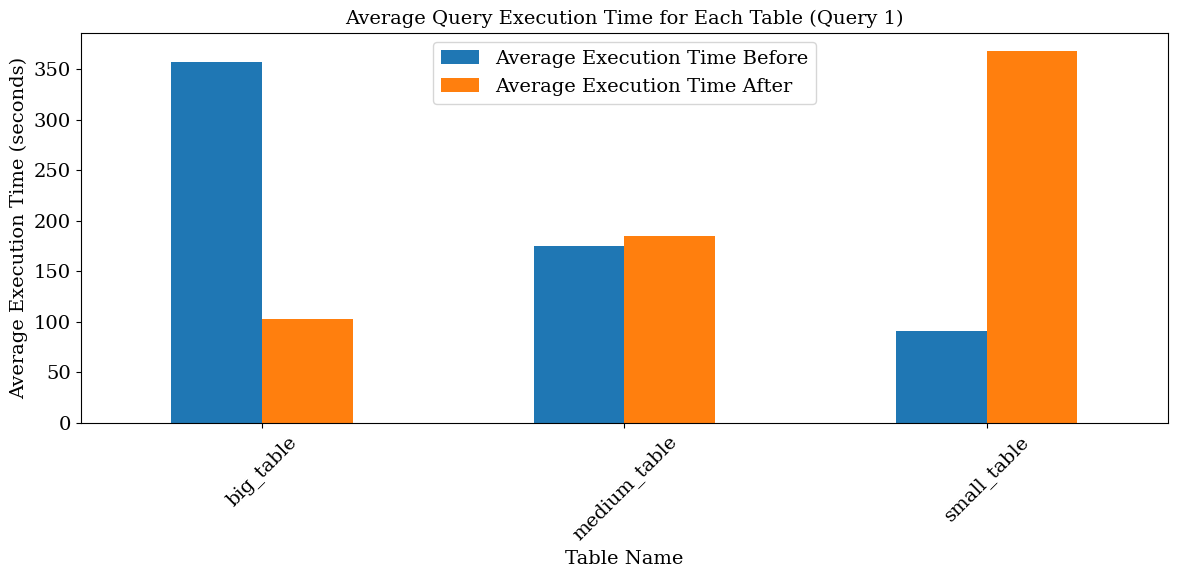

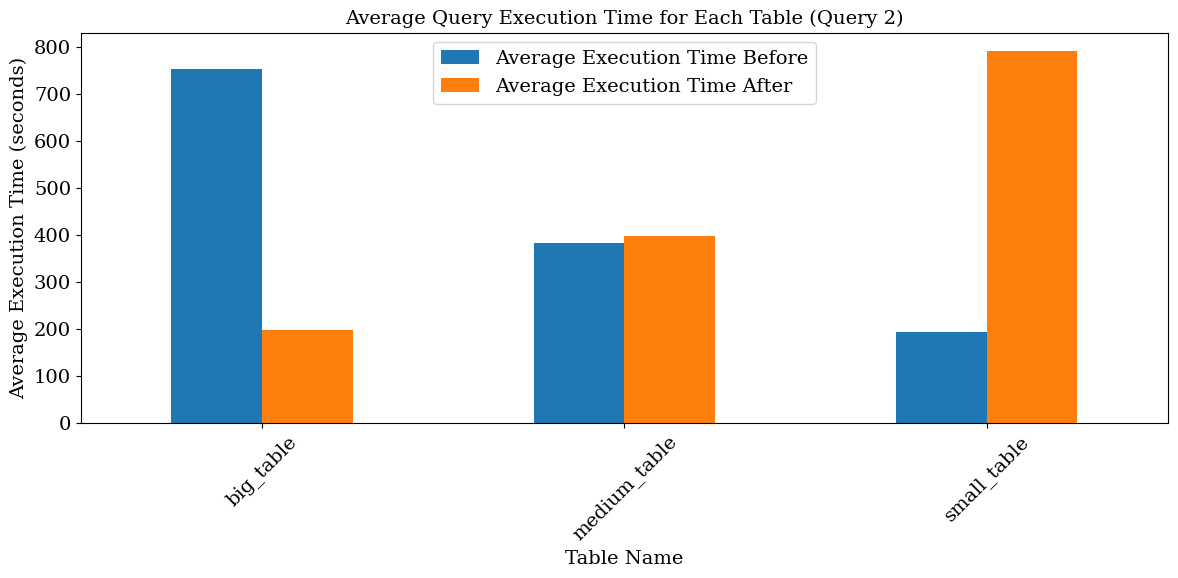

24/08/03 21:46:17 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
24/08/03 21:46:17 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce

In [103]:
plot_comparison(average_times_query1_before, average_times_query1_after, 1)
plot_comparison(average_times_query2_before, average_times_query2_after, 2)